In [1]:
from typing import Dict, List, Union
import os
import sys
import pytz
import pickle
import squarify

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator

from glob import glob
from collections import Counter
from datetime import datetime
from pathlib import Path

SAVEPATH = "./figure"
SAVEPKL = "../cluster_util/plot_pkl"

# KALOSPATH = "/mnt/petrelfs/share_data/wangzerui/llmtrace/cluster_util_ali/csv_full"
# KALOSPKL = "/mnt/petrelfs/share_data/wangzerui/llmtrace/cluster_util_ali/plot_pkl"
KALOSPATH = "../cluster_util/csv_full_ali"
KALOSPKL = "../cluster_util/plot_pkl_ali"

pd.set_option("display.max_columns", 500)

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
cmp = sns.color_palette("tab10")

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


def autolabel(rects, ax, prec=1):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.{prec}f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=16,
        )


def read_csv_with_concat(path="./csv", file_name=None):
    file = Path(path, f"{file_name}.csv")

    if file.exists():
        # If original file exists, read it directly
        df = pd.read_csv(file)
        print(f"Reading {file_name}")
    else:
        # If original file does not exist, read all the split files
        split_files = sorted(glob(f"{path}/{file_name}-2023-*.csv"))
        print(f"Reading splitted files: {split_files}")
        df = pd.concat([pd.read_csv(split_file) for split_file in split_files])
        df.reset_index(drop=True, inplace=True)
    return df


def calculate_sum_cdf_axis100(df, dot_num=1000):
    """
    Calculate quantity percentile CDF, y-axis: 0-100%,
    """
    print("Parsing")
    data = df.melt(id_vars="Time", var_name="Server")
    data.dropna(subset=["value"], inplace=True)
    # data.sort_values('value', ascending=True, inplace=True)
    # data.reset_index(drop=True, inplace=True)

    y = np.linspace(0, 1, num=dot_num)
    x = data["value"].quantile(y).values
    y = y * 100
    return x, y


def calculate_num_cdf_customized_xaxis(df: pd.DataFrame, x_axis: List, key: str):
    """
    Calculate quantity percentile CDF with customized threshold of x-axis, y-axis: 0-100%,
    """
    # print("Parsing")
    data = df[[key]].copy()
    data.dropna(inplace=True)

    y = [len(data[data[key] <= x]) / len(data) * 100 for x in x_axis]

    return y


def calculate_sum_cdf_customized_xaxis(df: pd.DataFrame, x_axis: List, key: str, key_to_time=None):
    """
    Calculate sum CDF with customized threshold of x-axis, y-axis: 0-100%,
    """
    # print("Parsing")
    if key_to_time is not None:
        data = df[[key, key_to_time]].copy()
        data["new"] = data[key] * data[key_to_time]
    else:
        data = df[[key]].copy()
        data["new"] = data[key]
    data.dropna(inplace=True)
    sum = data["new"].sum()

    y = [data[data[key] <= x]["new"].sum() / sum * 100 for x in x_axis]

    return y


def summarize_traces(trace_dict):
    df = pd.DataFrame(columns=["id"])
    df.set_index("id", drop=True, inplace=True)
    for cluster, log in trace_dict.items():
        clog = log[log["gpu_num"] == 0]
        glog = log[log["gpu_num"] > 0]

        df.at[cluster, "job_num"] = len(log)
        df.at[cluster, "cpu_job_num"] = len(clog)
        df.at[cluster, "gpu_job_num"] = len(glog)

        df.at[cluster, "avg_run_time_gpu"] = glog["duration"].mean()
        df.at[cluster, "avg_que_time_gpu"] = glog["queue"].mean()
        df.at[cluster, "avg_gpu_num"] = glog["gpu_num"].mean()

        df.at[cluster, "med_run_time_gpu"] = glog["duration"].median()
        df.at[cluster, "med_que_time_gpu"] = glog["queue"].median()
        df.at[cluster, "med_gpu_num"] = glog["gpu_num"].median()

        df.at[cluster, "max_run_time_gpu"] = glog["duration"].max()
        df.at[cluster, "max_gpu"] = glog["gpu_num"].max()

        if cluster != "PAI":
            df.at[cluster, "complete_rate_gpu"] = len(glog[glog["state"] == "COMPLETED"]) / len(glog)
            df.at[cluster, "cancel_rate_gpu"] = len(glog[glog["state"] == "CANCELLED"]) / len(glog)
            df.at[cluster, "fail_rate_gpu"] = 1 - df.at[cluster, "cancel_rate_gpu"] - df.at[cluster, "complete_rate_gpu"]

            glog = glog.copy()
            glog["gpu_time"] = glog["duration"] * glog["gpu_num"]
            gcomplete = glog[glog["state"] == "COMPLETED"]
            gcancel = glog[glog["state"] == "CANCELLED"]

            df.at[cluster, "complete_gpu_time"] = gcomplete["gpu_time"].sum()
            df.at[cluster, "cancel_gpu_time"] = gcancel["gpu_time"].sum()
            df.at[cluster, "fail_gpu_time"] = (
                glog["gpu_time"].sum() - df.at[cluster, "complete_gpu_time"] - df.at[cluster, "cancel_gpu_time"]
            )

            df.at[cluster, "complete_rate_gpu_time"] = gcomplete["gpu_time"].sum() / glog["gpu_time"].sum()
            df.at[cluster, "cancel_rate_gpu_time"] = gcancel["gpu_time"].sum() / glog["gpu_time"].sum()
            df.at[cluster, "fail_rate_gpu_time"] = df.at[cluster, "fail_gpu_time"] / glog["gpu_time"].sum()

        if len(clog) != 0:
            df.at[cluster, "avg_run_time_cpu"] = clog["duration"].mean()
            df.at[cluster, "avg_que_time_cpu"] = clog["queue"].mean()
            df.at[cluster, "med_run_time_cpu"] = clog["duration"].median()
            df.at[cluster, "med_que_time_cpu"] = clog["queue"].median()

            df.at[cluster, "complete_rate_cpu"] = len(clog[clog["state"] == "COMPLETED"]) / len(clog)
            df.at[cluster, "cancel_rate_cpu"] = len(clog[clog["state"] == "CANCELLED"]) / len(clog)
            df.at[cluster, "fail_rate_cpu"] = 1 - df.at[cluster, "cancel_rate_cpu"] - df.at[cluster, "complete_rate_cpu"]

        df = df.round(3)
        df[["job_num", "cpu_job_num", "gpu_job_num"]] = df[["job_num", "cpu_job_num", "gpu_job_num"]].astype(int)

        df.to_csv("./csv/cluster_summary.csv")


data_s = read_csv_with_concat(file_name="processed_job_trace")
data_ali = read_csv_with_concat(file_name="processed_ali_trace")
data_philly = pd.read_csv("./csv_previous_work/philly_trace.csv")
data_helios = pd.read_csv("./csv_previous_work/helios_trace.csv")
data_pai = pd.read_csv("./csv_previous_work/pai_trace.csv")

# A few further process
data_pai.rename(columns={"plan_cpu": "cpu_num", "plan_gpu": "gpu_num", "wait_time": "queue", "status": "state"}, inplace=True)
data_pai[["cpu_num", "gpu_num"]] /= 100
data_pai["state"] = data_pai["state"].map({"Failed": "FAILED"})  # Not suitable for final state analysis
data_philly["state"] = data_philly["state"].map({"Pass": "COMPLETED", "Failed": "FAILED", "Killed": "CANCELLED"})

trace_dict = {"Seren": data_s, "Kalos": data_ali, "Philly": data_philly, "Helios": data_helios, "PAI": data_pai}
summarize_traces(trace_dict)

Reading processed_job_trace
Reading processed_ali_trace


#### Data Processing

Please refer to `alillm2_analysis.ipynb` and `full_llm_partition_analysis.ipynb` to obtain processed traces

#### CDF: GPU Job Duration & Utilization

In [12]:
x1 = [2**i for i in range(0, 22)]
y_gpu_s = calculate_num_cdf_customized_xaxis(data_s[data_s["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_ali = calculate_num_cdf_customized_xaxis(data_ali[data_ali["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_philly = calculate_num_cdf_customized_xaxis(data_philly[data_philly["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_helios = calculate_num_cdf_customized_xaxis(data_helios[data_helios["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_pai = calculate_num_cdf_customized_xaxis(data_pai[data_pai["gpu_num"] > 0], x_axis=x1, key="duration")

# with open(f'{SAVEPKL}/util_gpu_util_mem_s.pkl', "rb") as file:
#     xx1, y1, x2, y2 = pickle.load(file)

with open(f"../cluster_util/plot_pkl_zm/util_gpu_s5.pkl", "rb") as file:
    # xx1, y1= pickle.load(file)
    xx1, y1, _, _, _, _, _, _, _, _ = pickle.load(file)

with open(f"{KALOSPKL}/util_gpu_util_mem_s.pkl", "rb") as file:
    x4, y4, x5, y5 = pickle.load(file)

with open(f"{SAVEPKL}/util_gpu_util_philly.pkl", "rb") as file:
    x3, y3 = pickle.load(file)

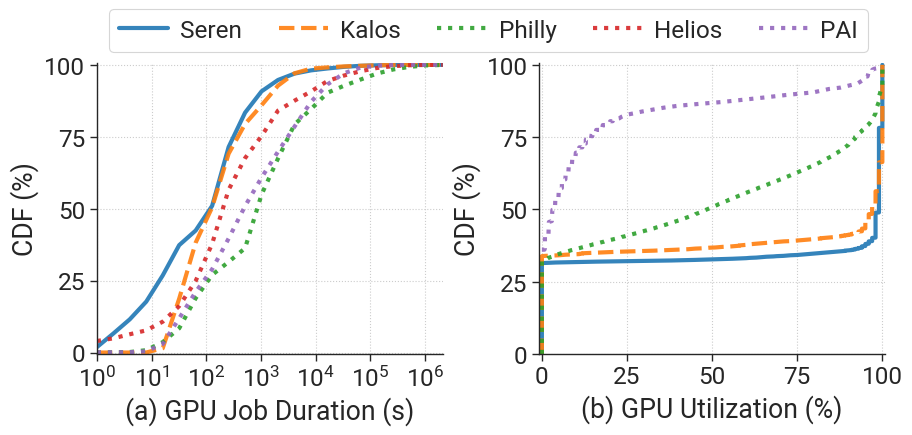

In [13]:
linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

ax1.plot(x1, y_gpu_s, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax1.plot(x1, y_gpu_ali, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax1.plot(x1, y_gpu_philly, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")
ax1.plot(x1, y_gpu_helios, linestyles[3], linewidth=3, alpha=0.9, color=cmp[3], label="Helios")
ax1.plot(x1, y_gpu_pai, linestyles[3], linewidth=3, alpha=0.9, color=cmp[4], label="PAI")

ax2.plot(xx1, y1, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax2.plot(x4, y4, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax2.plot(x3, y3, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")

# Add Antman, Philly Trace
df = pd.read_csv("../cluster_util/util_trace_antman_philly.csv")
ali_gutil = df.loc[:, ["ali_gpuutil_x", "ali_gpuutil_y"]].dropna()
ax2.plot(
    ali_gutil["ali_gpuutil_x"], ali_gutil["ali_gpuutil_y"], linestyles[2], label="PAI", linewidth=3, alpha=0.9, color=cmp[4]
)

ax1.set_xlabel(f"(a) GPU Job Duration (s)")
# ax1.set_ylabel(f"Fraction of Jobs (%)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xscale("log")
ax1.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
ax1.set_xlim(1, x1[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend(loc="lower right")
# ax1.legend(bbox_to_anchor=(0.51, 0.71))
ax1.grid(linestyle=":")
# ax1.text(0.45, -0.36, "(a)", transform=ax1.transAxes, size=20)

ax2.set_xlabel(f"(b) GPU Utilization (%)")
ax2.set_ylabel(f"CDF (%)")
ax2.set_xlim(-0.8, 100.8)
ax2.set_xticks([0, 25, 50, 75, 100])
ax2.set_ylim(0, 100.8)
# ax2.legend(loc="lower right")
ax2.grid(linestyle=":")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, ncols=5, bbox_to_anchor=(0.1, 1.145), loc=2, columnspacing=1.5, handletextpad=0.5)

sns.despine()
fig.savefig(f"{SAVEPATH}/cdf_job_duration_util.pdf", bbox_inches="tight")

#### CDF: GPU Job Duration & Queuing Delay

In [12]:
x1 = [2**i for i in range(0, 22)]
y_gpu_s = calculate_num_cdf_customized_xaxis(data_s[data_s["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_ali = calculate_num_cdf_customized_xaxis(data_ali[data_ali["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_philly = calculate_num_cdf_customized_xaxis(data_philly[data_philly["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_helios = calculate_num_cdf_customized_xaxis(data_helios[data_helios["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_pai = calculate_num_cdf_customized_xaxis(data_pai[data_pai["gpu_num"] > 0], x_axis=x1, key="duration")

x2 = [2**i for i in range(0, 16)]
y_que_s = calculate_num_cdf_customized_xaxis(data_s[data_s["gpu_num"] > 0], x_axis=x2, key="queue")
y_que_ali = calculate_num_cdf_customized_xaxis(data_ali[data_ali["gpu_num"] > 0], x_axis=x2, key="queue")
y_que_philly = calculate_num_cdf_customized_xaxis(data_philly[data_philly["gpu_num"] > 0], x_axis=x2, key="queue")
y_que_helios = calculate_num_cdf_customized_xaxis(data_helios[data_helios["gpu_num"] > 0], x_axis=x2, key="queue")
y_que_pai = calculate_num_cdf_customized_xaxis(data_pai[data_pai["gpu_num"] > 0], x_axis=x2, key="queue")

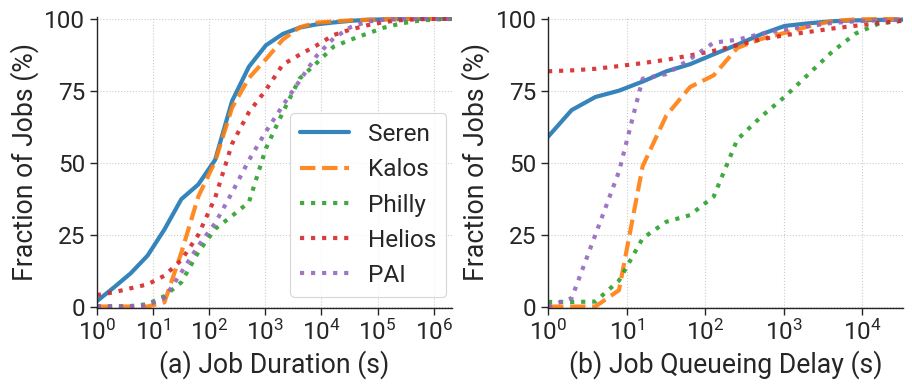

In [16]:
linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

ax1.plot(x1, y_gpu_s, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax1.plot(x1, y_gpu_ali, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax1.plot(x1, y_gpu_philly, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")
ax1.plot(x1, y_gpu_helios, linestyles[3], linewidth=3, alpha=0.9, color=cmp[3], label="Helios")
ax1.plot(x1, y_gpu_pai, linestyles[3], linewidth=3, alpha=0.9, color=cmp[4], label="PAI")

ax2.plot(x2, y_que_s, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax2.plot(x2, y_que_ali, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax2.plot(x2, y_que_philly, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")
ax2.plot(x2, y_que_helios, linestyles[3], linewidth=3, alpha=0.9, color=cmp[3], label="Helios")
ax2.plot(x2, y_que_pai, linestyles[3], linewidth=3, alpha=0.9, color=cmp[4], label="PAI")

ax1.set_xlabel(f"(a) Job Duration (s)")
ax1.set_ylabel(f"Fraction of Jobs (%)")
# ax1.set_ylabel(f"CDF (%)")
ax1.set_xscale("log")
ax1.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
ax1.set_xlim(1, x1[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend(loc="lower right")
ax1.legend(bbox_to_anchor=(0.51, 0.71))
ax1.grid(linestyle=":")
# ax1.text(0.45, -0.36, "(a)", transform=ax1.transAxes, size=20)

ax2.set_xlabel(f"(b) Job Queuing Delay (s)")
ax2.set_ylabel(f"Fraction of Jobs (%)")
# ax2.set_ylabel(f"CDF (%)")
ax2.set_xscale("log")
ax2.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax2.set_xlim(1, x2[-1])
ax2.set_ylim(-0.5, 100.8)
# ax2.legend(loc="lower right")
ax2.grid(linestyle=":")
# ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=20)

sns.despine()
fig.savefig(f"{SAVEPATH}/cdf_job_duration_queue.pdf", bbox_inches="tight")

#### CDF: Job Time

In [2]:
x1 = [2**i for i in range(0, 22)]
y_gpu_s = calculate_num_cdf_customized_xaxis(data_s[data_s["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_ali = calculate_num_cdf_customized_xaxis(data_ali[data_ali["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_philly = calculate_num_cdf_customized_xaxis(data_philly[data_philly["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_helios = calculate_num_cdf_customized_xaxis(data_helios[data_helios["gpu_num"] > 0], x_axis=x1, key="duration")
y_gpu_pai = calculate_num_cdf_customized_xaxis(data_pai[data_pai["gpu_num"] > 0], x_axis=x1, key="duration")

x2 = [2**i for i in range(0, 16)]
y_cpu_s = calculate_num_cdf_customized_xaxis(data_s[data_s["gpu_num"] == 0], x_axis=x2, key="duration")
y_cpu_ali = calculate_num_cdf_customized_xaxis(data_ali[data_ali["gpu_num"] == 0], x_axis=x2, key="duration")
# y_cpu_philly = calculate_num_cdf_customized_xaxis(data_philly[data_philly["gpu_num"] == 0], x_axis = x2, key = 'duration')
y_cpu_helios = calculate_num_cdf_customized_xaxis(data_helios[data_helios["gpu_num"] == 0], x_axis=x2, key="duration")
# y_cpu_pai = calculate_num_cdf_customized_xaxis(data_pai[data_pai["gpu_num"] == 0], x_axis = x2, key = 'duration'

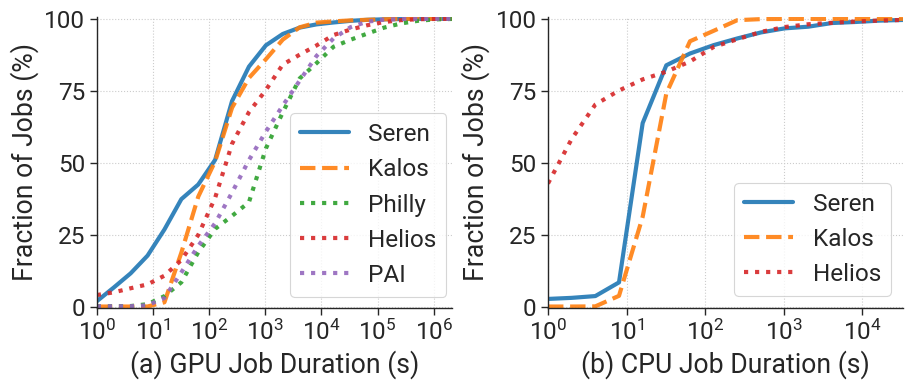

In [3]:
linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

ax1.plot(x1, y_gpu_s, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax1.plot(x1, y_gpu_ali, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax1.plot(x1, y_gpu_philly, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")
ax1.plot(x1, y_gpu_helios, linestyles[3], linewidth=3, alpha=0.9, color=cmp[3], label="Helios")
ax1.plot(x1, y_gpu_pai, linestyles[3], linewidth=3, alpha=0.9, color=cmp[4], label="PAI")

ax2.plot(x2, y_cpu_s, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax2.plot(x2, y_cpu_ali, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
# ax2.plot(x2, y_cpu_philly, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")
ax2.plot(x2, y_cpu_helios, linestyles[3], linewidth=3, alpha=0.9, color=cmp[3], label="Helios")
# ax2.plot(x2, y_cpu_pai, linestyles[3], linewidth=3, alpha=0.9, color=cmp[4], label="PAI")

ax1.set_xlabel(f"(a) GPU Job Duration (s)")
ax1.set_ylabel(f"Fraction of Jobs (%)")
# ax1.set_ylabel(f"CDF (%)")
ax1.set_xscale("log")
ax1.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
ax1.set_xlim(1, x1[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend(loc="lower right")
ax1.legend(bbox_to_anchor=(0.51, 0.71))
ax1.grid(linestyle=":")
# ax1.text(0.45, -0.36, "(a)", transform=ax1.transAxes, size=20)

ax2.set_xlabel(f"(b) CPU Job Duration (s)")
ax2.set_ylabel(f"Fraction of Jobs (%)")
# ax2.set_ylabel(f"CDF (%)")
ax2.set_xscale("log")
ax2.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax2.set_xlim(1, x2[-1])
ax2.set_ylim(-0.5, 100.8)
ax2.legend(loc="lower right")
ax2.grid(linestyle=":")
# ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=20)

sns.despine()
fig.savefig(f"{SAVEPATH}/cdf_job_jobtime.pdf", bbox_inches="tight")

#### CDF: GPU Number

In [3]:
x1 = [i for i in range(0, 1025)]
# x1 = [2 ** (i/5) for i in range(0, 101)]
# x1 = [2 ** i for i in range(0, 11)]
y_gpu_s = calculate_num_cdf_customized_xaxis(data_s[data_s["gpu_num"] > 0], x_axis=x1, key="gpu_num")
y_gpu_ali = calculate_num_cdf_customized_xaxis(data_ali[data_ali["gpu_num"] > 0], x_axis=x1, key="gpu_num")
y_gpu_philly = calculate_num_cdf_customized_xaxis(data_philly[data_philly["gpu_num"] > 0], x_axis=x1, key="gpu_num")
y_gpu_helios = calculate_num_cdf_customized_xaxis(data_helios[data_helios["gpu_num"] > 0], x_axis=x1, key="gpu_num")
y_gpu_pai = calculate_num_cdf_customized_xaxis(data_pai[data_pai["gpu_num"] > 0], x_axis=x1, key="gpu_num")

y_gtime_s = calculate_sum_cdf_customized_xaxis(data_s[data_s["gpu_num"] > 0], x_axis=x1, key="gpu_num", key_to_time="duration")
y_gtime_ali = calculate_sum_cdf_customized_xaxis(
    data_ali[data_ali["gpu_num"] > 0], x_axis=x1, key="gpu_num", key_to_time="duration"
)
y_gtime_philly = calculate_sum_cdf_customized_xaxis(
    data_philly[data_philly["gpu_num"] > 0], x_axis=x1, key="gpu_num", key_to_time="duration"
)
y_gtime_helios = calculate_sum_cdf_customized_xaxis(
    data_helios[data_helios["gpu_num"] > 0], x_axis=x1, key="gpu_num", key_to_time="duration"
)
y_gtime_pai = calculate_sum_cdf_customized_xaxis(
    data_pai[data_pai["gpu_num"] > 0], x_axis=x1, key="gpu_num", key_to_time="duration"
)

In [18]:
y_gpu_helios[8]

94.69042002854859

In [20]:
y_gtime_s[1]

1.7955782475671356

In [27]:
y_gtime_ali[8]

0.6243535867745756

In [22]:
y_gtime_pai[1]

68.12483759505676

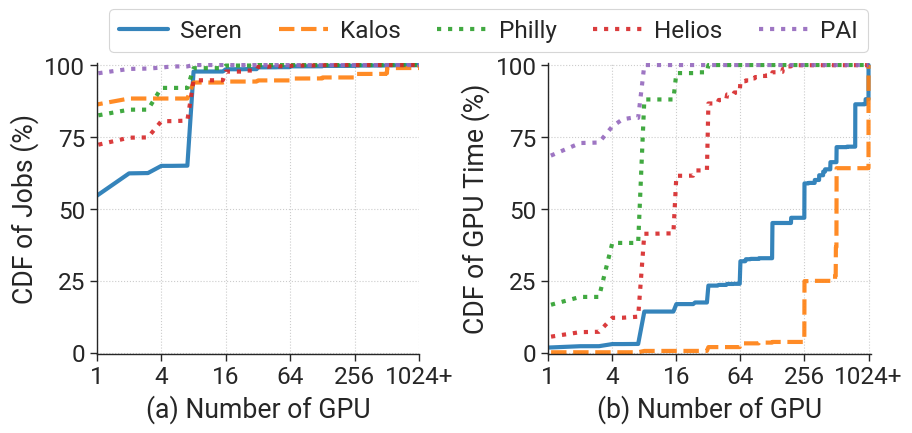

In [4]:
linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

ax1.plot(x1, y_gpu_s, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax1.plot(x1, y_gpu_ali, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax1.plot(x1, y_gpu_philly, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")
ax1.plot(x1, y_gpu_helios, linestyles[3], linewidth=3, alpha=0.9, color=cmp[3], label="Helios")
ax1.plot(x1, y_gpu_pai, linestyles[3], linewidth=3, alpha=0.9, color=cmp[4], label="PAI")

ax2.plot(x1, y_gtime_s, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax2.plot(x1, y_gtime_ali, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax2.plot(x1, y_gtime_philly, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="Philly")
ax2.plot(x1, y_gtime_helios, linestyles[3], linewidth=3, alpha=0.9, color=cmp[3], label="Helios")
ax2.plot(x1, y_gtime_pai, linestyles[3], linewidth=3, alpha=0.9, color=cmp[4], label="PAI")


ax1.set_xlabel(f"(a) Number of GPU")
# ax1.set_ylabel(f"Fraction of Jobs (%)")
ax1.set_ylabel(f"CDF of Jobs (%)")
ax1.set_xscale("log", base=2)
ax1.set_xticks([2**i for i in range(0, 11, 2)])
ax1.set_xticklabels(
    [2**i for i in range(0, 10, 2)]
    + [
        "1024+",
    ]
)
ax1.set_xlim(1, x1[-1] + 1)
ax1.set_ylim(-0.5, 100.8)
# ax1.legend(loc="lower right")
ax1.grid(linestyle=":")
# ax1.text(0.45, -0.36, "(a)", transform=ax1.transAxes, size=20)


ax2.set_xlabel(f"(b) Number of GPU")
# ax2.set_ylabel(f"Fraction of GPU Time (%)")
ax2.set_ylabel(f"CDF of GPU Time (%)")
ax2.set_xscale("log", base=2)
ax2.set_xticks([2**i for i in range(0, 11, 2)])
ax2.set_xticklabels(
    [2**i for i in range(0, 10, 2)]
    + [
        "1024+",
    ]
)
ax2.set_xlim(1, x1[-1] + 50)
ax2.set_ylim(-0.5, 100.8)
# ax2.legend(loc="lower right")
ax2.grid(linestyle=":")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, ncols=5, bbox_to_anchor=(0.1, 1.145), loc=2, columnspacing=1.5, handletextpad=0.5)

sns.despine()
fig.savefig(f"{SAVEPATH}/cdf_job_gpunum.pdf", bbox_inches="tight")

#### Bar: Job Final State

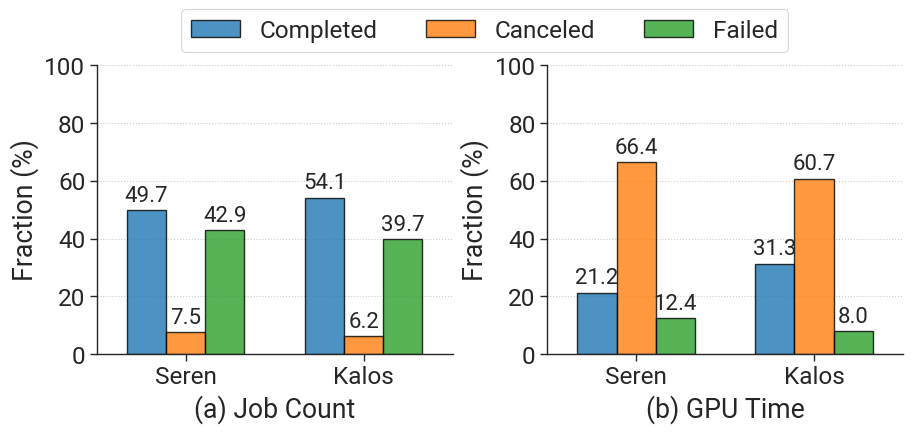

In [25]:
df = pd.read_csv("./csv/cluster_summary.csv", index_col="id")
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

x = np.arange(1, 3)
width = 0.22
p1 = ax1.bar(
    x - width,
    df.loc[["Seren", "Kalos"], "complete_rate_gpu"] * 100,
    width,
    label="Completed",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
)
p2 = ax1.bar(
    x, df.loc[["Seren", "Kalos"], "cancel_rate_gpu"] * 100, width, label="Canceled", alpha=0.8, linewidth=1, edgecolor="k"
)
p3 = ax1.bar(
    x + width, df.loc[["Seren", "Kalos"], "fail_rate_gpu"] * 100, width, label="Failed", alpha=0.8, linewidth=1, edgecolor="k"
)

p4 = ax2.bar(
    x - width,
    df.loc[["Seren", "Kalos"], "complete_rate_gpu_time"] * 100,
    width,
    label="Completed",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
)
p5 = ax2.bar(
    x, df.loc[["Seren", "Kalos"], "cancel_rate_gpu_time"] * 100, width, label="Canceled", alpha=0.8, linewidth=1, edgecolor="k"
)
p6 = ax2.bar(
    x + width,
    df.loc[["Seren", "Kalos"], "fail_rate_gpu_time"] * 100,
    width,
    label="Failed",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
)

autolabel(p1, ax1)
autolabel(p2, ax1)
autolabel(p3, ax1)
autolabel(p4, ax2)
autolabel(p5, ax2)
autolabel(p6, ax2)

ax1.set_xlabel(f"(a) Job Count")
ax1.set_ylabel(f"Fraction (%)")
ax1.set_xticks(x)
ax1.set_xticklabels(["Seren", "Kalos"])
ax1.set_xlim(0.5, 2.5)
ax1.set_ylim(0, 100)
ax1.grid(axis="y", linestyle=":")

ax2.set_xlabel(f"(b) GPU Time")
ax2.set_ylabel(f"Fraction (%)")
ax2.set_xticks(x)
ax2.set_xticklabels(["Seren", "Kalos"])
ax2.set_xlim(0.5, 2.5)
ax2.set_ylim(0, 100)
ax2.grid(axis="y", linestyle=":")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    ncols=5,
    bbox_to_anchor=(0.18, 1.145),
    loc=2,
    #   columnspacing=1, handletextpad=0.2
)

sns.despine()
fig.savefig(f"{SAVEPATH}/bar_job_state.pdf", bbox_inches="tight")

#### Treemap: Job Number Distribution

In [185]:
print("Processing Seren")
data = data_s[data_s["gpu_num"] > 0]
data = data[~data["vc"].str.contains("3dobject")]
series = data["vc"].value_counts()
data = data.copy()
data["gpu_time"] = data["duration"] * data["gpu_num"]
gtime = data.groupby("vc")["gpu_time"].sum()

mllm_df = data[data["vc"].str.contains("mllm")]
sft_df = data[(data["vc"].str.contains("_it")) | (data["vc"].str.contains("_exam"))]
no_mllm = data[~(data["vc"].str.contains("mllm") | (data["vc"].str.contains("_it")) | (data["vc"].str.contains("_exam")))]

sft_df = pd.concat([sft_df, no_mllm[(no_mllm["jobname"].str.contains("sft", case=False))]])
no_mllm = no_mllm[~(no_mllm["jobname"].str.contains("sft", case=False))]

eval_df = no_mllm[
    (no_mllm["jobname"].str.contains("eval", case=False))
    | (no_mllm["jobname"].str.contains("infer", case=False))
    | (no_mllm["jobname"].str.contains("score", case=False))
    | (no_mllm["vc"].str.contains("eval", case=False))
]
no_eval = no_mllm[
    ~(
        (no_mllm["jobname"].str.contains("eval", case=False))
        | (no_mllm["jobname"].str.contains("infer", case=False))
        | (no_mllm["jobname"].str.contains("score", case=False))
        | (no_mllm["vc"].str.contains("eval", case=False))
    )
]

debug_df = no_eval[
    (no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False))
]
no_debug = no_eval[
    ~((no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False)))
]

pretrain_df = no_debug[no_debug["gpu_num"] > 32]
other_df = no_debug[no_debug["gpu_num"] <= 32]

data["type"] = None
data.loc[eval_df.index, "type"] = "Eval"
data.loc[debug_df.index, "type"] = "Debug"
data.loc[sft_df.index, "type"] = "Fine-tuning"
data.loc[pretrain_df.index, "type"] = "Pretrain"
data.loc[other_df.index, "type"] = "Other"
data.loc[mllm_df.index, "type"] = "MLLM"

# data.to_csv('./csv/s_trace_with_type.csv', index=None)

job_type = ["Evaluation", "Pretrain", "Fine-tuning", "MLLM", "Debug", "Other"]
df = pd.DataFrame(job_type)
df = df.set_index(0)

df.at["Evaluation", "job_count"] = len(eval_df)
df.at["Fine-tuning", "job_count"] = len(sft_df)
df.at["Pretrain", "job_count"] = len(pretrain_df)
df.at["MLLM", "job_count"] = len(mllm_df)
df.at["Debug", "job_count"] = len(debug_df)
df.at["Other", "job_count"] = len(other_df)

df.at["Evaluation", "gtime"] = eval_df["gpu_time"].sum()
df.at["Fine-tuning", "gtime"] = sft_df["gpu_time"].sum()
df.at["Pretrain", "gtime"] = pretrain_df["gpu_time"].sum()
df.at["MLLM", "gtime"] = mllm_df["gpu_time"].sum()
df.at["Debug", "gtime"] = debug_df["gpu_time"].sum()
df.at["Other", "gtime"] = other_df["gpu_time"].sum()

total = df["job_count"].sum()
total_gtime = df["gtime"].sum()

df["count_percent"] = df["job_count"] / total * 100
df["gtime_percent"] = df["gtime"] / total_gtime * 100

df["label"] = [x + f"\n{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime"] = [x + f"\n{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]

df["label_percent"] = [f"{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime_percent"] = [f"{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]
df
df_s = df.copy()

Processing Seren


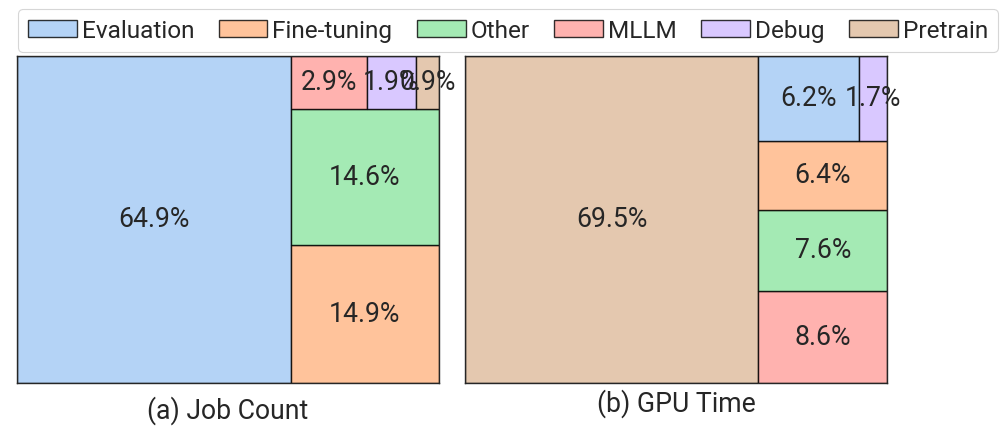

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))
cmp_treemap = sns.color_palette("pastel")

df.sort_values(by="count_percent", ascending=False, inplace=True)
df["color"] = cmp_treemap[: len(df)]

squarify.plot(
    ax=ax1,
    sizes=list(df["job_count"].values),
    label=df["label_percent"],
    color=df["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles=handles, labels=list(df.index), ncols=6, bbox_to_anchor=(0, 1.145), loc=2, columnspacing=1, handletextpad=0.2
)

df.sort_values(by="gtime", ascending=False, inplace=True)

squarify.plot(
    ax=ax2,
    sizes=list(df["gtime"].values),
    label=df["label_gtime_percent"],
    color=df["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

# plt.axis('off')
plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_xlabel(f"(a) Job Count")
ax2.set_xlabel(f"(b) GPU Time")

fig.savefig(f"{SAVEPATH}/treemap_job_dist.pdf", bbox_inches="tight")

In [4]:
print("Processing Kalos")
data = data_ali[data_ali["gpu_num"] > 0]
data = data.copy()
data["gpu_time"] = data["duration"] * data["gpu_num"]

eval_df = data[
    (data["jobname"].str.contains("eval", case=False))
    | (data["jobname"].str.contains("infer", case=False))
    | (data["jobname"].str.contains("score", case=False))
]
no_eval = data[
    ~(
        (data["jobname"].str.contains("eval", case=False))
        | (data["jobname"].str.contains("infer", case=False))
        | (data["jobname"].str.contains("score", case=False))
    )
]

debug_df = no_eval[
    (no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False))
]
no_debug = no_eval[
    ~((no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False)))
]

sft_df = no_debug[(no_debug["jobname"].str.contains("sft", case=False))]
no_sft = no_debug[~(no_debug["jobname"].str.contains("sft", case=False))]

pretrain_df = no_sft[no_sft["gpu_num"] > 64]
other_df = no_sft[no_sft["gpu_num"] <= 64]

data["type"] = None
data.loc[eval_df.index, "type"] = "Eval"
data.loc[debug_df.index, "type"] = "Debug"
data.loc[sft_df.index, "type"] = "Fine-tuning"
data.loc[pretrain_df.index, "type"] = "Pretrain"
data.loc[other_df.index, "type"] = "Other"

eval_df = pd.concat([eval_df, no_sft[no_sft["gpu_num"] <= 32]])
eval_df = pd.concat([eval_df, sft_df])
# pretrain_df = pretrain_df[:-90]
pretrain_df = pretrain_df.sort_values(by="gpu_time", ascending=False)[5:]

# data.to_csv('./csv/ali_trace_with_type.csv', index=None)

# job_type = ["Evaluation", "Fine-tuning", "Pretrain", "Debug", "Other"]
job_type = ["Evaluation", "Pretrain", "Debug", "Other"]
df = pd.DataFrame(job_type)
df = df.set_index(0)

df.at["Evaluation", "job_count"] = len(eval_df)
# df.at["Fine-tuning", "job_count"] = len(sft_df)
df.at["Pretrain", "job_count"] = len(pretrain_df)
df.at["Debug", "job_count"] = len(debug_df)
df.at["Other", "job_count"] = len(other_df)

df.at["Evaluation", "gtime"] = eval_df["gpu_time"].sum()
# df.at["Fine-tuning", "gtime"] = sft_df['gpu_time'].sum()
df.at["Pretrain", "gtime"] = pretrain_df["gpu_time"].sum()
df.at["Debug", "gtime"] = debug_df["gpu_time"].sum()
df.at["Other", "gtime"] = other_df["gpu_time"].sum()

total = df["job_count"].sum()
total_gtime = df["gtime"].sum()

df["count_percent"] = df["job_count"] / total * 100
df["gtime_percent"] = df["gtime"] / total_gtime * 100

df["label"] = [x + f"\n{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime"] = [x + f"\n{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]

df["label_percent"] = [f"{df.at[x, 'count_percent']:.1f}\n%" for x in list(df.index)]
df["label_gtime_percent"] = [f"{df.at[x, 'gtime_percent']:.1f}\n%" for x in list(df.index)]
df_k = df.copy()
df

Processing Kalos


,job_count,gtime,count_percent,gtime_percent,label,label_gtime,label_percent,label_gtime_percent
0,,,,,,,,
Evaluation,18672.0,1.130237e+08,92.918636,2.650862,Evaluation\n92.9%,Evaluation\n2.7%,92.9\n%,2.7\n%
Pretrain,636.0,3.932708e+09,3.164966,92.237890,Pretrain\n3.2%,Pretrain\n92.2%,3.2\n%,92.2\n%
Debug,537.0,8.444178e+07,2.672307,1.980501,Debug\n2.7%,Debug\n2.0%,2.7\n%,2.0\n%
Other,250.0,1.334843e+08,1.244091,3.130746,Other\n1.2%,Other\n3.1%,1.2\n%,3.1\n%


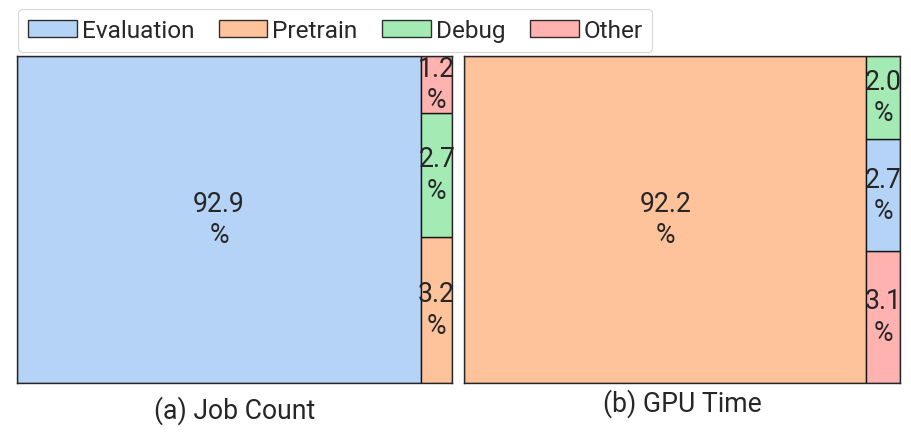

In [95]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))
cmp_treemap = sns.color_palette("pastel")

df.sort_values(by="count_percent", ascending=False, inplace=True)
df["color"] = cmp_treemap[: len(df)]

squarify.plot(
    ax=ax1,
    sizes=list(df["job_count"].values),
    label=df["label_percent"],
    color=df["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles=handles, labels=list(df.index), ncols=5, bbox_to_anchor=(0, 1.145), loc=2, columnspacing=1, handletextpad=0.2
)

df.sort_values(by="gtime", ascending=False, inplace=True)

squarify.plot(
    ax=ax2,
    sizes=list(df["gtime"].values),
    label=df["label_gtime_percent"],
    color=df["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

# plt.axis('off')
plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_xlabel(f"(a) Job Count")
ax2.set_xlabel(f"(b) GPU Time")

fig.savefig(f"{SAVEPATH}/treemap_job_dist.pdf", bbox_inches="tight")

##### Paper plot

In [2]:
print("Processing Seren")
data = data_s[data_s["gpu_num"] > 0]
data = data[~data["vc"].str.contains("3dobject")]
series = data["vc"].value_counts()
data = data.copy()
data["gpu_time"] = data["duration"] * data["gpu_num"]
gtime = data.groupby("vc")["gpu_time"].sum()

mllm_df = data[data["vc"].str.contains("mllm")]
sft_df = data[(data["vc"].str.contains("_it")) | (data["vc"].str.contains("_exam"))]
no_mllm = data[~(data["vc"].str.contains("mllm") | (data["vc"].str.contains("_it")) | (data["vc"].str.contains("_exam")))]

sft_df = pd.concat([sft_df, no_mllm[(no_mllm["jobname"].str.contains("sft", case=False))]])
no_mllm = no_mllm[~(no_mllm["jobname"].str.contains("sft", case=False))]

eval_df = no_mllm[
    (no_mllm["jobname"].str.contains("eval", case=False))
    | (no_mllm["jobname"].str.contains("infer", case=False))
    | (no_mllm["jobname"].str.contains("score", case=False))
    | (no_mllm["vc"].str.contains("eval", case=False))
]
no_eval = no_mllm[
    ~(
        (no_mllm["jobname"].str.contains("eval", case=False))
        | (no_mllm["jobname"].str.contains("infer", case=False))
        | (no_mllm["jobname"].str.contains("score", case=False))
        | (no_mllm["vc"].str.contains("eval", case=False))
    )
]

debug_df = no_eval[
    (no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False))
]
no_debug = no_eval[
    ~((no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False)))
]

pretrain_df = no_debug[no_debug["gpu_num"] > 32]
other_df = no_debug[no_debug["gpu_num"] <= 32]

data["type"] = None
data.loc[eval_df.index, "type"] = "Eval"
data.loc[debug_df.index, "type"] = "Debug"
data.loc[sft_df.index, "type"] = "Fine-tuning"
data.loc[pretrain_df.index, "type"] = "Pretrain"
data.loc[other_df.index, "type"] = "Other"
data.loc[mllm_df.index, "type"] = "MLLM"

# data.to_csv('./csv/s_trace_with_type.csv', index=None)

job_type = ["Evaluation", "Pretrain", "SFT", "MLLM", "Debug", "Other"]
df = pd.DataFrame(job_type)
df = df.set_index(0)

df.at["Evaluation", "job_count"] = len(eval_df)
df.at["SFT", "job_count"] = len(sft_df)
df.at["Pretrain", "job_count"] = len(pretrain_df)
df.at["MLLM", "job_count"] = len(mllm_df)
df.at["Debug", "job_count"] = len(debug_df)
df.at["Other", "job_count"] = len(other_df)

df.at["Evaluation", "gtime"] = eval_df["gpu_time"].sum()
df.at["SFT", "gtime"] = sft_df["gpu_time"].sum()
df.at["Pretrain", "gtime"] = pretrain_df["gpu_time"].sum()
df.at["MLLM", "gtime"] = mllm_df["gpu_time"].sum()
df.at["Debug", "gtime"] = debug_df["gpu_time"].sum()
df.at["Other", "gtime"] = other_df["gpu_time"].sum()

total = df["job_count"].sum()
total_gtime = df["gtime"].sum()

df["count_percent"] = df["job_count"] / total * 100
df["gtime_percent"] = df["gtime"] / total_gtime * 100

df["label"] = [x + f"\n{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime"] = [x + f"\n{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]

df["label_percent"] = [f"{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime_percent"] = [f"{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]
df_s = df.copy()

print("Processing Kalos")
data = data_ali[data_ali["gpu_num"] > 0]
data = data.copy()
data["gpu_time"] = data["duration"] * data["gpu_num"]

eval_df = data[
    (data["jobname"].str.contains("eval", case=False))
    | (data["jobname"].str.contains("infer", case=False))
    | (data["jobname"].str.contains("score", case=False))
]
no_eval = data[
    ~(
        (data["jobname"].str.contains("eval", case=False))
        | (data["jobname"].str.contains("infer", case=False))
        | (data["jobname"].str.contains("score", case=False))
    )
]

debug_df = no_eval[
    (no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False))
]
no_debug = no_eval[
    ~((no_eval["jobname"].str.contains("debug", case=False)) | (no_eval["jobname"].str.contains("test", case=False)))
]

sft_df = no_debug[(no_debug["jobname"].str.contains("sft", case=False))]
no_sft = no_debug[~(no_debug["jobname"].str.contains("sft", case=False))]

pretrain_df = no_sft[no_sft["gpu_num"] > 64]
other_df = no_sft[no_sft["gpu_num"] <= 64]

data["type"] = None
data.loc[eval_df.index, "type"] = "Eval"
data.loc[debug_df.index, "type"] = "Debug"
data.loc[sft_df.index, "type"] = "Fine-tuning"
data.loc[pretrain_df.index, "type"] = "Pretrain"
data.loc[other_df.index, "type"] = "Other"

# For better visualization
eval_df = pd.concat([eval_df, no_sft[no_sft["gpu_num"] <= 8]])
pretrain_df = pretrain_df.sort_values(by="gpu_time", ascending=False)[5:]

# data.to_csv('./csv/ali_trace_with_type.csv', index=None)

# job_type = ["Evaluation", "Fine-tuning", "Pretrain", "Debug", "Other"]
job_type = ["Evaluation", "Pretrain", "Debug", "Other"]
df = pd.DataFrame(job_type)
df = df.set_index(0)

df.at["Evaluation", "job_count"] = len(eval_df)
# df.at["Fine-tuning", "job_count"] = len(sft_df)
df.at["Pretrain", "job_count"] = len(pretrain_df)
df.at["Debug", "job_count"] = len(debug_df)
df.at["Other", "job_count"] = len(other_df)

df.at["Evaluation", "gtime"] = eval_df["gpu_time"].sum()
# df.at["Fine-tuning", "gtime"] = sft_df['gpu_time'].sum()
df.at["Pretrain", "gtime"] = pretrain_df["gpu_time"].sum()
df.at["Debug", "gtime"] = debug_df["gpu_time"].sum()
df.at["Other", "gtime"] = other_df["gpu_time"].sum()

total = df["job_count"].sum()
total_gtime = df["gtime"].sum()

df["count_percent"] = df["job_count"] / total * 100
df["gtime_percent"] = df["gtime"] / total_gtime * 100

df["label"] = [x + f"\n{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime"] = [x + f"\n{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]

df["label_percent"] = [f"{df.at[x, 'count_percent']:.1f}\n%" for x in list(df.index)]
df["label_gtime_percent"] = [f"{df.at[x, 'gtime_percent']:.1f}\n%" for x in list(df.index)]
df_k = df.copy()

FONT = 15
df_k.at["Pretrain", "label_gtime_percent"] = df_k.at["Pretrain", "label_gtime"]
df_k.at["Evaluation", "label_percent"] = df_k.at["Evaluation", "label"]
df_k.at["Other", "label_percent"] = ""
df_k.at["Evaluation", "label_gtime_percent"] = " "

df_s.at["Pretrain", "label_gtime_percent"] = df_s.at["Pretrain", "label_gtime"]
df_s.at["Evaluation", "label_percent"] = df_s.at["Evaluation", "label"]
df_s.at["SFT", "label_percent"] = df_s.at["SFT", "label"]
df_s.at["Other", "label_percent"] = df_s.at["Other", "label"]
df_s.at["Pretrain", "label_percent"] = " "
df_s.at["Debug", "label_gtime_percent"] = df_s.at["Debug", "label_gtime_percent"].replace("%", "\n%")


cmp_treemap = sns.color_palette("pastel")
label = df_s.index.to_list()
df_s["color"] = cmp_treemap[: len(df_s)]

Processing Seren
Processing Kalos


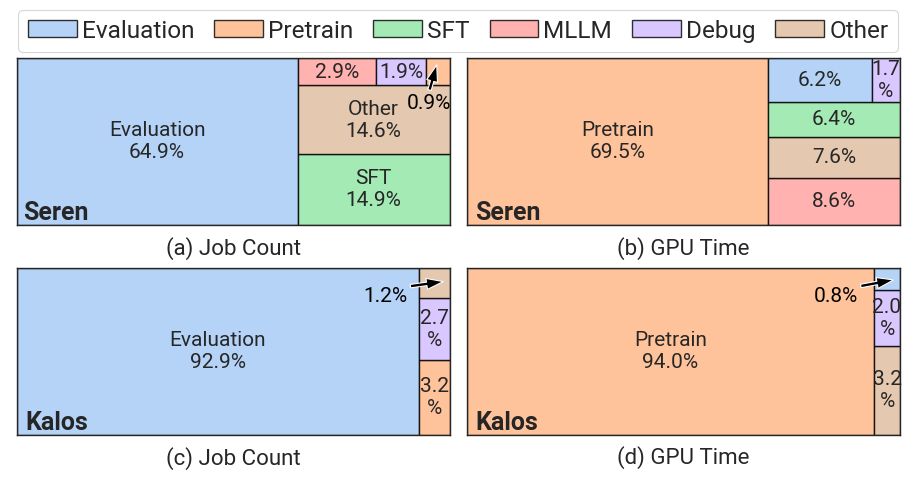

In [3]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(9, 4.2))

###### Fig 1 ######
df_s.sort_values(by="count_percent", ascending=False, inplace=True)
squarify.plot(
    ax=ax1,
    sizes=list(df_s["job_count"].values),
    label=df_s["label_percent"],
    text_kwargs={"fontsize": FONT},
    color=df_s["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)


handles, labels = ax1.get_legend_handles_labels()
handles_new = [handles[0], handles[-1], handles[1], handles[3], handles[4], handles[2]]
# labels_new = [df_s.index[0], df_s.index[-1], df_s.index[1], df_s.index[2], df_s.index[3], df_s.index[4]]
fig.legend(
    handles=handles_new,
    labels=label,
    ncols=6,
    bbox_to_anchor=(0.0, 1.135),
    loc=2,
    columnspacing=0.82,
    handletextpad=0.2,
    # fontsize=16
)

###### Fig 2 ######
df_s.sort_values(by="gtime", ascending=False, inplace=True)
squarify.plot(
    ax=ax2,
    sizes=list(df_s["gtime"].values),
    label=df_s["label_gtime_percent"],
    text_kwargs={"fontsize": FONT},
    color=df_s["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

# plt.axis('off')
plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_xlabel(f"(a) Job Count", fontsize=16)
ax2.set_xlabel(f"(b) GPU Time", fontsize=16)


###### Fig 3 ######
df_k.sort_values(by="count_percent", ascending=False, inplace=True)
df_k["color"] = [df_s["color"][job_name] for job_name in df_k.index]

squarify.plot(
    ax=ax3,
    sizes=list(df_k["job_count"].values),
    label=df_k["label_percent"],
    text_kwargs={"fontsize": FONT},
    color=df_k["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

###### Fig 4 ######
df_k.sort_values(by="gtime", ascending=False, inplace=True)
squarify.plot(
    ax=ax4,
    sizes=list(df_k["gtime"].values),
    label=df_k["label_gtime_percent"],
    text_kwargs={"fontsize": FONT},
    color=df_k["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

ax1.annotate(
    df_s.at["Pretrain", "label"].split("\n")[1],
    xy=(97, 96),
    xytext=(90, 70),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)

ax3.annotate(
    df_k.at["Other", "label"].split("\n")[1],
    xy=(98.5, 92),
    xytext=(80, 80),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)

ax4.annotate(
    df_k.at["Evaluation", "label_gtime"].split("\n")[1],
    xy=(98.5, 93),
    xytext=(80, 80),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)

plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

ax3.set_xlabel(f"(c) Job Count", fontsize=16)
ax4.set_xlabel(f"(d) GPU Time", fontsize=16, labelpad=8)

ax1.text(0.015, 0.03, "Seren", transform=ax1.transAxes, size=18, fontweight="bold")
ax2.text(0.02, 0.03, "Seren", transform=ax2.transAxes, size=18, fontweight="bold")
ax3.text(0.02, 0.03, "Kalos", transform=ax3.transAxes, size=18, fontweight="bold")
ax4.text(0.02, 0.03, "Kalos", transform=ax4.transAxes, size=18, fontweight="bold")
fig.savefig(f"{SAVEPATH}/treemap_job_dist.pdf", bbox_inches="tight")

#### CDF: Duration and Queuing Delay of Different Type

In [3]:
"""4 Figures in One: (a) Seren Duration (b) Seren Queuing  (c) Kalos Duration (d) Kalos Queuing
You can refer CDF: GPU Job Duration & Queuing Delay
"""

print("NOTE: Only consider GPU Jobs here!  NOTE: According `type`")
data_seren = pd.read_csv("./csv/s_trace_with_type.csv")
data_kalos = pd.read_csv("./csv/ali_trace_with_type.csv")
# Duration part
x1 = [2**i for i in range(0, 22)]
y_gpu_s_other = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Other")], x_axis=x1, key="duration"
)
y_gpu_s_debug = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Debug")], x_axis=x1, key="duration"
)
y_gpu_s_pretrain = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Pretrain")], x_axis=x1, key="duration"
)
y_gpu_s_eval = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Eval")], x_axis=x1, key="duration"
)
y_gpu_s_tuning = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Fine-tuning")], x_axis=x1, key="duration"
)
y_gpu_s_mllm = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "MLLM")], x_axis=x1, key="duration"
)

y_gpu_ali_other = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Other")], x_axis=x1, key="duration"
)
y_gpu_ali_debug = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Debug")], x_axis=x1, key="duration"
)
y_gpu_ali_pretrain = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Pretrain")], x_axis=x1, key="duration"
)
y_gpu_ali_eval = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Eval")], x_axis=x1, key="duration"
)
y_gpu_ali_tuning = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Fine-tuning")], x_axis=x1, key="duration"
)

# Queuing part
x2 = [2**i for i in range(0, 16)]
y_que_s_other = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Other")], x_axis=x2, key="queue"
)
y_que_s_debug = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Debug")], x_axis=x2, key="queue"
)
y_que_s_pretrain = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Pretrain")], x_axis=x2, key="queue"
)
y_que_s_eval = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Eval")], x_axis=x2, key="queue"
)
y_que_s_tuning = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Fine-tuning")], x_axis=x2, key="queue"
)
y_que_s_mllm = calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "MLLM")], x_axis=x2, key="queue"
)

y_que_ali_other = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Other")], x_axis=x2, key="queue"
)
y_que_ali_debug = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Debug")], x_axis=x2, key="queue"
)
y_que_ali_pretrain = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Pretrain")], x_axis=x2, key="queue"
)
y_que_ali_eval = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Eval")], x_axis=x2, key="queue"
)
y_que_ali_tuning = calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Fine-tuning")], x_axis=x2, key="queue"
)

NOTE: Only consider GPU Jobs here!  NOTE: According `type`


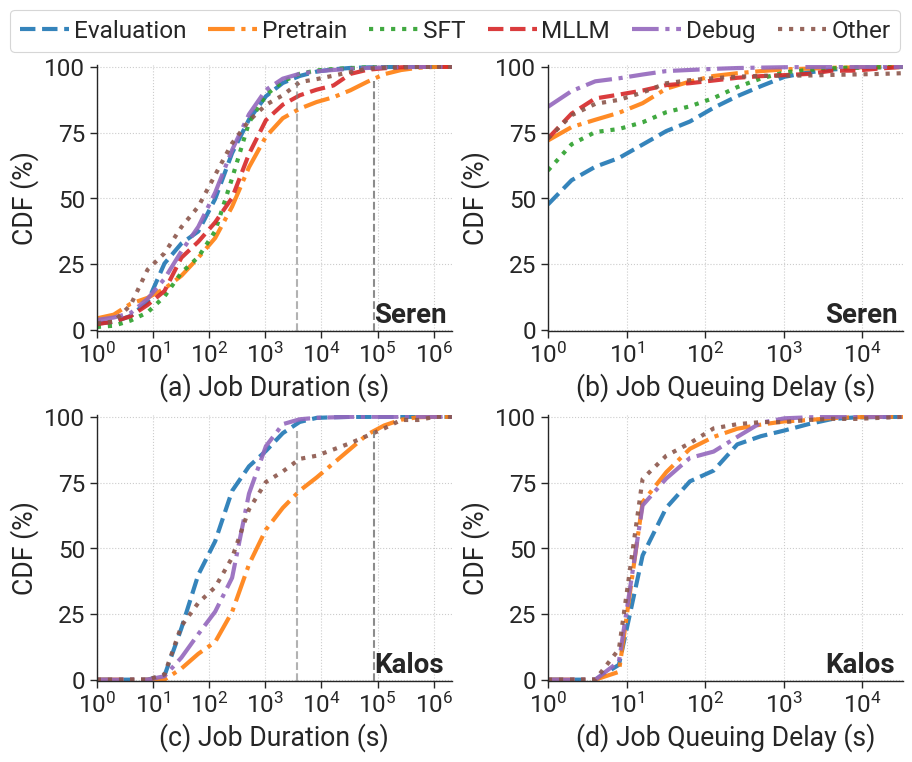

In [17]:
linestyles = ["--", "-.", ":", "--", "-.", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(9, 7))

# (a) Seren Duration
ax1.plot(x1, y_gpu_s_eval, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Evaluation")
ax1.plot(x1, y_gpu_s_pretrain, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Pretrain")
ax1.plot(x1, y_gpu_s_tuning, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="SFT")
ax1.plot(x1, y_gpu_s_mllm, linestyles[0], linewidth=3, alpha=0.9, color=cmp[3], label="MLLM")
ax1.plot(x1, y_gpu_s_debug, linestyles[1], linewidth=3, alpha=0.9, color=cmp[4], label="Debug")
ax1.plot(x1, y_gpu_s_other, linestyles[2], linewidth=3, alpha=0.9, color=cmp[5], label="Other")


# (b) Seren Queuing
ax2.plot(x2, y_que_s_eval, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Evaluation")
ax2.plot(x2, y_que_s_pretrain, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Pretrain")
ax2.plot(x2, y_que_s_tuning, linestyles[2], linewidth=3, alpha=0.9, color=cmp[2], label="SFT")
ax2.plot(x2, y_que_s_mllm, linestyles[0], linewidth=3, alpha=0.9, color=cmp[3], label="MLLM")
ax2.plot(x2, y_que_s_debug, linestyles[1], linewidth=3, alpha=0.9, color=cmp[4], label="Debug")
ax2.plot(x2, y_que_s_other, linestyles[2], linewidth=3, alpha=0.9, color=cmp[5], label="Other")

# (c) Kalos Duration
ax3.plot(x1, y_gpu_ali_eval, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Evaluation")
ax3.plot(x1, y_gpu_ali_pretrain, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Pretrain")
# ax3.plot(x1, y_gpu_ali_tuning, linestyles[4], linewidth=3, alpha=0.9, color=cmp[2], label="Fine-tuning")
ax3.plot(x1, y_gpu_ali_debug, linestyles[1], linewidth=3, alpha=0.9, color=cmp[4], label="Debug")
ax3.plot(x1, y_gpu_ali_other, linestyles[2], linewidth=3, alpha=0.9, color=cmp[5], label="Other")


# (d) Kalos Queuing
ax4.plot(x2, y_que_ali_eval, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Evaluation")
ax4.plot(x2, y_que_ali_pretrain, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Pretrain")
# ax4.plot(x2, y_que_ali_tuning, linestyles[4], linewidth=3, alpha=0.9, color=cmp[2], label="Fine-tuning")
ax4.plot(x2, y_que_ali_debug, linestyles[1], linewidth=3, alpha=0.9, color=cmp[4], label="Debug")
ax4.plot(x2, y_que_ali_other, linestyles[2], linewidth=3, alpha=0.9, color=cmp[5], label="Other")

ax1.set_xlabel(f"(a) Job Duration (s)")
# ax1.set_ylabel(f"Fraction of Jobs (%)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xscale("log")
ax1.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
ax1.set_xlim(1, x1[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend(loc="lower right")
handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    ncols=6,
    bbox_to_anchor=(-0.01, 1.08),
    loc=2,
    columnspacing=0.9,
    handletextpad=0.2,
    #   fontsize=17
)
ax1.grid(linestyle=":")
# ax1.text(0.45, -0.36, "(a)", transform=ax1.transAxes, size=20)

ax2.set_xlabel(f"(b) Job Queuing Delay (s)")
# ax2.set_ylabel(f"Fraction of Jobs (%)")
ax2.set_ylabel(f"CDF (%)")
ax2.set_xscale("log")
ax2.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax2.set_xlim(1, x2[-1])
ax2.set_ylim(-0.5, 100.8)
# ax2.legend(loc="lower right")
ax2.grid(linestyle=":")
# ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=20)

ax3.set_xlabel(f"(c) Job Duration (s)")
# ax3.set_ylabel(f"Fraction of Jobs (%)")
ax3.set_ylabel(f"CDF (%)")
ax3.set_xscale("log")
ax3.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
ax3.set_xlim(1, x1[-1])
ax3.set_ylim(-0.5, 100.8)
# ax1.legend(loc="lower right")
# ax3.legend(bbox_to_anchor=(0.51, 0.71), fontsize=12)
ax3.grid(linestyle=":")
# ax1.text(0.45, -0.36, "(a)", transform=ax1.transAxes, size=20)

ax4.set_xlabel(f"(d) Job Queuing Delay (s)")
# ax4.set_ylabel(f"Fraction of Jobs (%)")
ax4.set_ylabel(f"CDF (%)")
ax4.set_xscale("log")
ax4.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax4.set_xlim(1, x2[-1])
ax4.set_ylim(-0.5, 100.8)
# ax2.legend(loc="lower right")
ax4.grid(linestyle=":")
# ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=20)

ax1.axvline(x=3600, ls="--", alpha=0.6, c="gray", ymax=0.94, lw=1.5)
ax1.axvline(x=3600 * 24, ls="--", alpha=0.9, c="gray", ymax=0.94, lw=1.5)
ax3.axvline(x=3600, ls="--", alpha=0.6, c="gray", ymax=0.94, lw=1.5)
ax3.axvline(x=3600 * 24, ls="--", alpha=0.9, c="gray", ymax=0.94, lw=1.5)

sns.despine()
ax1.text(0.78, 0.03, "Seren", transform=ax1.transAxes, size=20, fontweight="bold")
ax2.text(0.78, 0.03, "Seren", transform=ax2.transAxes, size=20, fontweight="bold")
ax3.text(0.78, 0.03, "Kalos", transform=ax3.transAxes, size=20, fontweight="bold")
ax4.text(0.78, 0.03, "Kalos", transform=ax4.transAxes, size=20, fontweight="bold")

fig.savefig(f"{SAVEPATH}/cdf_job_duration_queue.pdf", bbox_inches="tight")

In [22]:
calculate_num_cdf_customized_xaxis(
    data_seren[(data_seren["gpu_num"] > 0) & (data_seren["type"] == "Pretrain")], x_axis=[3600, 3600 * 24], key="duration"
)

[83.50720317933433, 95.85196224540486]

In [24]:
calculate_num_cdf_customized_xaxis(
    data_kalos[(data_kalos["gpu_num"] > 0) & (data_kalos["type"] == "Pretrain")], x_axis=[3600, 3600 * 24], key="duration"
)

[71.45085803432137, 95.3198127925117]

#### Box Plot: Request GPU number Different Type

In [4]:
print("NOTE: Only consider GPU Jobs here!  NOTE: According `type`")
data_seren = pd.read_csv("./csv/s_trace_with_type.csv")
data_kalos = pd.read_csv("./csv/ali_trace_with_type.csv")

NOTE: Only consider GPU Jobs here!  NOTE: According `type`


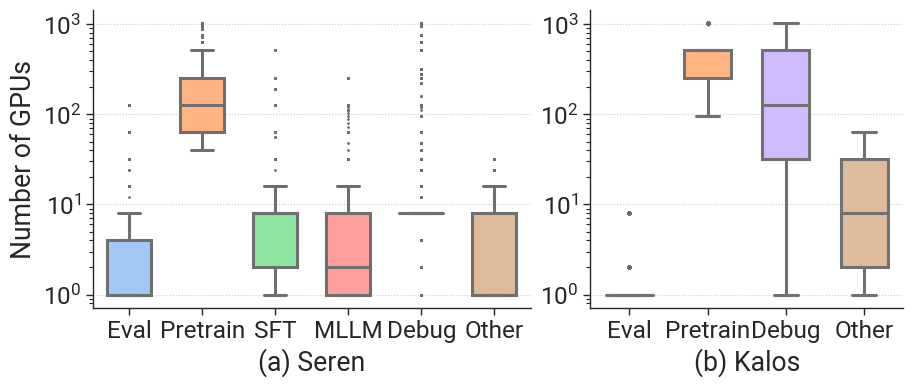

In [5]:
cmap = sns.color_palette("pastel")  #
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    gridspec_kw={"width_ratios": [4.2, 3]},
    constrained_layout=True,
    figsize=(9, 3.75),
)

############ Fig 1 ############
data_seren.sort_values(by="gpu_num", ascending=False, inplace=True)
data_seren["type"].replace("Fine-tuning", "SFT", inplace=True)
# data_seren['type'].replace("Debug", "DB", inplace=True)
# data_kalos['type'].replace("Debug", "DB", inplace=True)

x_ticks = [
    "Eval",
    "Pretrain",
    "SFT",
    "MLLM",
    "Debug",
    "Other",
]
# my_pal = {x_ticks[0]: cmp[1], x_ticks[1]: cmp[4], x_ticks[2]: cmp[2], x_ticks[3]: cmp[3], x_ticks[4]: cmp[0], x_ticks[5]: cmp[5]}
# my_pal = [cmp[1], cmp[4], cmp[5], cmp[3], cmp[0], cmp[2]]


flierprops = dict(marker=".", markerfacecolor="k", markersize=2, linestyle="none")
sns.boxplot(
    x="type",
    y="gpu_num",
    data=data_seren,
    flierprops=flierprops,
    width=0.6,
    linewidth=2.2,
    saturation=2,
    palette=cmap,
    ax=ax1,
    # fliersize=1,
    order=x_ticks,
    boxprops=dict(alpha=1),
)
sns.color_palette("tab10")
ax1.set_xlabel("(a) Seren")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel(f"Number of GPUs")
ax1.set_yscale("log")
# ax1.set_ylim(0, 900)
ax1.grid(axis="y", linestyle=":")


############ Fig 2 ############
data_kalos.sort_values(by="gpu_num", ascending=False, inplace=True)
data_kalos = data_kalos[data_kalos["type"] != "Fine-tuning"]
x_ticks_k = [
    "Eval",
    "Pretrain",
    "Debug",
    "Other",
]
# my_pal = {x_ticks_k[0]: cmp[1], x_ticks_k[1]: cmp[4], x_ticks_k[2]: cmp[2], x_ticks_k[3]: cmp[0], x_ticks_k[4]: cmp[5]}
my_pal = [cmap[0], cmap[1], cmap[4], cmap[5]]

flierprops = dict(marker=".", markerfacecolor="k", markersize=3, linestyle="none")
sns.boxplot(
    x="type",
    y="gpu_num",
    data=data_kalos,
    flierprops=flierprops,
    width=0.6,
    linewidth=2.2,
    saturation=2,
    palette=my_pal,
    ax=ax2,
    order=x_ticks_k,
    boxprops=dict(alpha=1),
)
sns.color_palette("tab10")
ax2.set_xlabel("(b) Kalos")
ax2.set_ylabel(None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
# ax2.set_ylabel(f"Request GPU number")
ax2.set_yscale("log")
# ax1.set_ylim(0, 900)
ax2.grid(axis="y", linestyle=":")

# ax1.text(0.8, 0.9, "Seren", transform=ax1.transAxes, size=18,fontweight='bold')
# ax2.text(0.8, 0.9, "Kalos", transform=ax2.transAxes, size=18,fontweight='bold')
sns.despine()
fig.savefig(f"{SAVEPATH}/box_gpu_num.pdf", bbox_inches="tight")

#### Plot: Average Job submit number and request GPU number  (per hour)

In [76]:
from datetime import timedelta

# Process Seren data per hour
print("Processing Seren")
date_range = ("2023-03-01 00:00:00", "2023-08-17 23:50:00")
log = pd.read_csv(f"./csv/s_trace_with_type.csv", parse_dates=["submit_time", "start_time", "end_time"])
df = pd.DataFrame(
    pd.date_range(start=date_range[0], end=date_range[1], freq="10T"),
    columns=["time"],
)
df[
    [
        "submit_job_all",
        "start_job_all",
        "end_job_all",
        "submit_gpu_job",
        "start_gpu_job",
        "end_gpu_job",
        "submit_gpu_num",
        "start_gpu_num",
        "end_gpu_num",
    ]
] = 0
df["time"] = df.time.dt.tz_localize("UTC+08:00")
df.set_index("time", inplace=True, drop=True)

for i in range(len(df)):
    for kind in ("submit", "start", "end"):
        jobs = log[(log[kind + "_time"] >= df.index[i]) & (log[kind + "_time"] < df.index[i] + timedelta(minutes=10))]
        df[kind + "_job_all"][i] = len(jobs)
        df[kind + "_gpu_job"][i] = len(jobs[jobs["gpu_num"] != 0])
        df[kind + "_gpu_num"][i] = jobs["gpu_num"].agg(sum)

# Process Kalos data per hour
print("Processing Kalos")
date_range = ("2023-05-17 00:00:00", "2023-08-17 23:50:00")
log_k = pd.read_csv(f"./csv/ali_trace_with_type.csv", parse_dates=["submit_time", "start_time", "end_time"])
df_k = pd.DataFrame(
    pd.date_range(start=date_range[0], end=date_range[1], freq="10T"),
    columns=["time"],
)
df_k[
    [
        "submit_job_all",
        "start_job_all",
        "end_job_all",
        "submit_gpu_job",
        "start_gpu_job",
        "end_gpu_job",
        "submit_gpu_num",
        "start_gpu_num",
        "end_gpu_num",
    ]
] = 0
df_k["time"] = df_k.time.dt.tz_localize("UTC+08:00")
df_k.set_index("time", inplace=True, drop=True)

for i in range(len(df_k)):
    for kind in ("submit", "start", "end"):
        jobs = log_k[(log_k[kind + "_time"] >= df_k.index[i]) & (log_k[kind + "_time"] < df_k.index[i] + timedelta(minutes=10))]
        df_k[kind + "_job_all"][i] = len(jobs)
        df_k[kind + "_gpu_job"][i] = len(jobs[jobs["gpu_num"] != 0])
        df_k[kind + "_gpu_num"][i] = jobs["gpu_num"].agg(sum)

Processing Seren
Processing Kalos


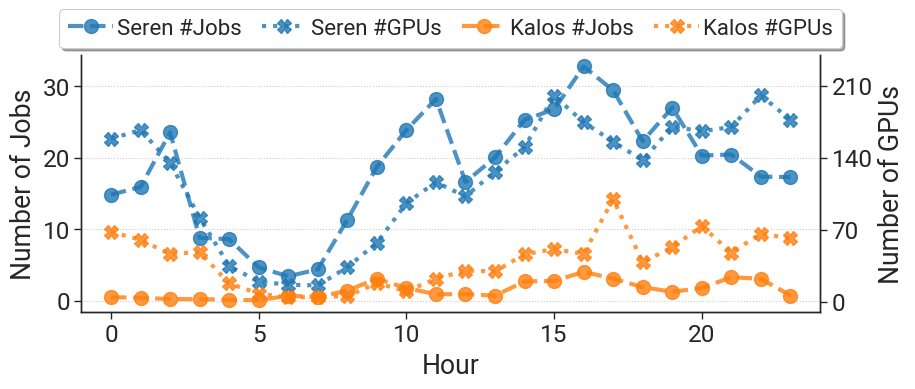

In [134]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.75))
linestyles = ["--o", ":X", "--o", ":X"]

############ Fig 1 ############
day_sub_mean, day_req_gpu = [], []
for i in range(0, 24):
    day_sub_mean.append(df[df.index.hour == i]["submit_gpu_job"].agg("mean"))
    day_req_gpu.append(df[df.index.hour == i]["submit_gpu_num"].agg("mean"))
k_day_sub_mean, k_day_req_gpu = [], []
for i in range(0, 24):
    k_day_sub_mean.append(df_k[df_k.index.hour == i]["submit_gpu_job"].agg("mean"))
    k_day_req_gpu.append(df_k[df_k.index.hour == i]["submit_gpu_num"].agg("mean"))

(A,) = ax1.plot(np.arange(0, 24), day_sub_mean, linestyles[0], alpha=0.8, label="Seren #Jobs", color=cmp[0])
(C,) = ax1.plot(np.arange(0, 24), k_day_sub_mean, linestyles[0], alpha=0.8, label="Kalos #Jobs", color=cmp[1])

ax1.set_xlabel(f"Hour")
# ax1.set_ylabel(f"Submitted #Jobs")
ax1.set_ylabel(f"Number of Jobs")
ax1.set_yticks(np.arange(0, 32, 10))
ax1.grid(axis="y", linestyle=":")
ax1.set_xlim(-1, 24)

ax2 = ax1.twinx()
(B,) = ax2.plot(np.arange(0, 24), day_req_gpu, linestyles[1], alpha=0.8, label="Seren #GPUs", color=cmp[0])
(D,) = ax2.plot(np.arange(0, 24), k_day_req_gpu, linestyles[1], alpha=0.8, label="Kalos #GPUs", color=cmp[1])

# ax2.set_ylabel(f"Requested #GPUs")
ax2.set_ylabel(f"Number of GPUs")
ax2.set_ylim(-10, 240)
ax2.set_yticks(np.arange(0, 240, 70))

lns = [A, B, C, D]
labs = [l.get_label() for l in lns]
ax1.legend(
    lns,
    labs,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.22),
    ncol=4,
    fancybox=True,
    shadow=True,
    fontsize=16,
    columnspacing=0.9,
    handletextpad=0.2,
)
sns.despine(left=False, top=True, right=False)
# ax1.text(0.01, 0.03, "Seren", transform=ax1.transAxes, size=16,fontweight='bold')
fig.savefig(f"{SAVEPATH}/plot_hour_submission.pdf", bbox_inches="tight")

#### CDF: Resource Utilization

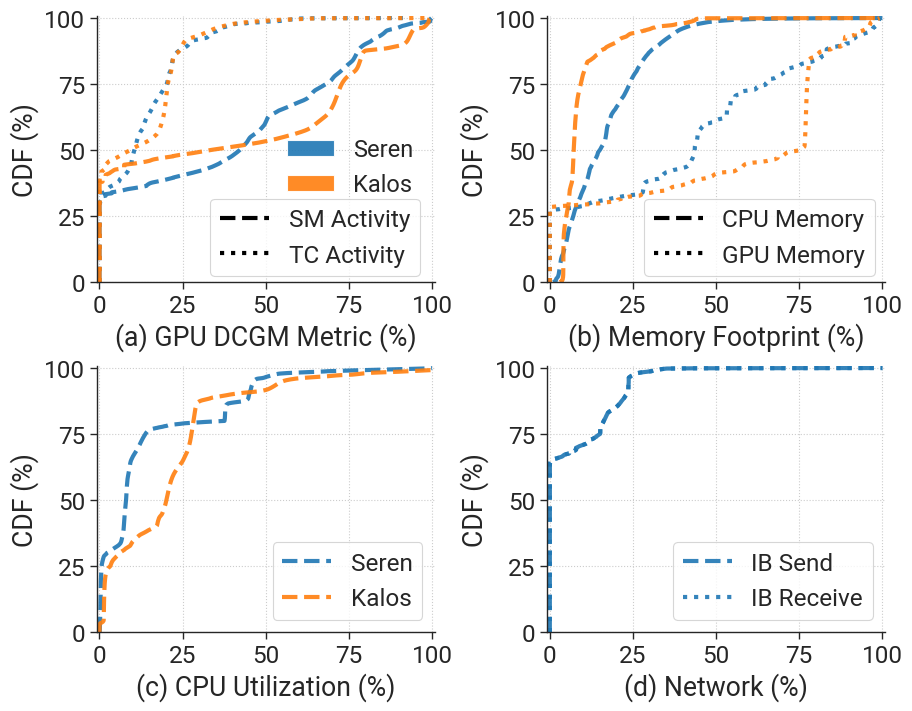

In [2]:
SAVEPKL = "../cluster_util/plot_pkl_zm"
with open(f"{SAVEPKL}/util_gpu_s6.pkl", "rb") as file:
    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5 = pickle.load(file)
# with open(f'{SAVEPKL}/util_gpu_k8.pkl', "rb") as file:
#     x1_k, y1_k, x2_k, y2_k, x3_k, y3_k, x4_k, y4_k, x5_k, y5_k = pickle.load(file)
with open(f"{SAVEPKL}/util_gpu_k8.pkl", "rb") as file:  # Use memory util only
    x1_k, y1_k, x2_k, y2_k, x3_k, y3_k, x4_k, y4_k, x5_k, y5_k = pickle.load(file)
with open(f"../cluster_util/plot_pkl_ali/util_gpu_ali_august_14_16.pkl", "rb") as file:  # Select 3 days with LLM
    x1_k, y1_k, _, _, x3_k, y3_k, x4_k, y4_k, x5_k, y5_k = pickle.load(file)
with open(f"../cluster_util/plot_pkl/util_cpu_mem_s.pkl", "rb") as file:
    x6, y6, x7, y7 = pickle.load(file)
with open(f"{SAVEPKL}/util_cpu_mem_k.pkl", "rb") as file:
    x6_k, y6_k, x7_k, y7_k = pickle.load(file)
with open(f"{SAVEPKL}/ib_cluster_s7.pkl", "rb") as file:
    x8, y8, x9, y9 = pickle.load(file)


x8 = x8 / x8.max() * 100
x9 = x9 / x9.max() * 100

linestyles = ["--", ":", "--", "-.", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(9, 7))

############ Fig 1: SM, Occupancy ############
ax1.plot(x3, y3, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren SM Activity")
ax1.plot(x5, y5, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="Seren Occupancy")
ax1.plot(x3_k, y3_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos SM Activity")
ax1.plot(x5_k, y5_k, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos Occupancy")

############ Fig 2: CPU mem usage, GPU mem usage ############
ax2.plot(x7, y7, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren CPU Mem")
ax2.plot(x2, y2, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="Seren GPU Mem")
ax2.plot(x7_k, y7_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos CPU Mem")
ax2.plot(x2_k, y2_k, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos GPU Mem")

############ Fig 3: CPU util ############
ax3.plot(x6, y6, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax3.plot(x6_k, y6_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")

############ Fig 4: IB send, receive ############
ax4.plot(x8, y8, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="IB Send")
ax4.plot(x9, y9, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="IB Receive")

ax1.set_xlabel(f"(a) GPU DCGM Metric (%)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xlim(-0.8, 100.8)
ax1.set_ylim(0, 100.8)
ax1.set_xticks([0, 25, 50, 75, 100])
# ax1.legend(loc="lower right")
ax1.grid(linestyle=":")

ax2.set_xlabel(f"(b) Memory Footprint (%)")
ax2.set_ylabel(f"CDF (%)")
ax2.set_xlim(-0.8, 100.8)
ax2.set_xticks([0, 25, 50, 75, 100])
ax2.set_ylim(0, 100.8)
# ax2.legend(loc="lower right")
ax2.grid(linestyle=":")

ax3.set_xlabel(f"(c) CPU Utilization (%)")
ax3.set_ylabel(f"CDF (%)")
ax3.set_xlim(-0.8, 100.8)
ax3.set_xticks([0, 25, 50, 75, 100])
ax3.set_ylim(0, 100.8)
ax3.legend(loc="lower right")
ax3.grid(linestyle=":")

ax4.set_xlabel(f"(d) Network (%)")
ax4.set_ylabel(f"CDF (%)")
ax4.set_xlim(-0.8, 100.8)
ax4.set_xticks([0, 25, 50, 75, 100])
ax4.set_ylim(0, 100.8)
ax4.legend(loc="lower right")
ax4.grid(linestyle=":")
sns.despine()


S = mpatches.Patch(facecolor=cmp[0], alpha=0.9)  # , edgecolor="black"
K = mpatches.Patch(facecolor=cmp[1], alpha=0.9)
A = (Line2D([0], [0], color="black", lw=3, ls="--"),)
B = (Line2D([0], [0], color="black", lw=3, ls=":"),)

legend1 = ax1.legend([S, K], ["Seren", "Kalos"], bbox_to_anchor=(0.5, 0.62), loc=2, ncol=1, fontsize=17, frameon=False)

ax1.add_artist(legend1)

ax1.legend([A, B], ["SM Activity", "TC Activity"], bbox_to_anchor=(0.3, 0.36), loc=2, ncol=1)

ax2.legend([A, B], ["CPU Memory", "GPU Memory"], bbox_to_anchor=(0.25, 0.36), loc=2, ncol=1)

fig.savefig(f"{SAVEPATH}/cdf_resource_util.pdf", bbox_inches="tight")

#### Treemap Power Analysis

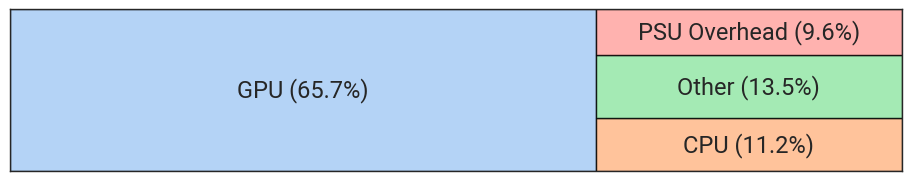

In [3]:
cmp_treemap = sns.color_palette("pastel")
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 1.7))

powers = [0.657, 0.112, 0.135, 0.096]
labels = ["GPU", "CPU", "Other", "PSU Overhead"]

df = pd.DataFrame(labels)
df = df.set_index(0)
df.at[:, "power"] = powers
df["percent"] = df["power"] / df["power"].sum() * 100
df["label"] = [x + f" ({df.at[x, 'percent']:.1f}%)" for x in list(df.index)]
df["label_percent"] = [f"{df.at[x, 'percent']:.1f}%" for x in list(df.index)]


squarify.plot(
    ax=ax1,
    sizes=df["percent"],
    label=df["label"],
    color=cmp_treemap,
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
    text_kwargs={"fontsize": 17},
)

ax1.set_xticks([])
ax1.set_yticks([])
# ax1.set_xlabel(f"(b) Treemap")
# ax1.legend(loc="lower right")
# ax1.grid(linestyle=":")

# sns.despine()
fig.savefig(f"{SAVEPATH}/treemap_power.pdf", bbox_inches="tight")

#### Treemap CPU Mem Analysis

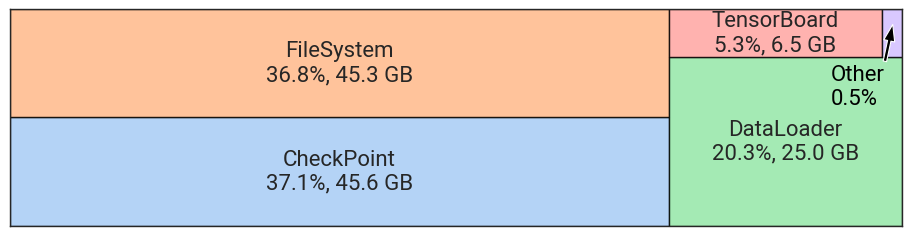

In [15]:
cmp_treemap = sns.color_palette("pastel")
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 2.25))

# powers = [224, 6.5, 0.4, 45.3, 0.2]
# labels = ['DataLoader', 'TensorBoard', 'Prometheus', 'FileSystem', 'Other']

powers = [25.0, 45.6, 6.5, 45.3, 0.6]
labels = ["DataLoader", "CheckPoint", "TensorBoard", "FileSystem", "Other"]


df = pd.DataFrame(labels)
df = df.set_index(0)
df.at[:, "power"] = powers
df["percent"] = df["power"] / df["power"].sum() * 100
df["label"] = [x + f"\n{df.at[x, 'percent']:.1f}%, {df.at[x, 'power']:.1f} GB" for x in list(df.index)]
df["label_percent"] = [f"{df.at[x, 'percent']:.1f}%" for x in list(df.index)]
df["label1"] = df["label"]

df.sort_values(by="power", ascending=False, inplace=True)

# df.at["TensorBoard", "label1"] = ' '
df.at["Other", "label1"] = " "


squarify.plot(
    ax=ax1,
    sizes=df["percent"],
    label=df["label1"],
    color=cmp_treemap,
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
    text_kwargs={"fontsize": 16},
)


# ax1.annotate(df.at["TensorBoard", "label"], xy=(90, 95), xytext = (66, 70), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=16)

ax1.annotate(
    df.at["Other", "label"].split(",")[0],
    xy=(99, 93),
    xytext=(92, 56),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)

ax1.set_xticks([])
ax1.set_yticks([])
# ax1.set_xlabel(f"(b) Treemap")
# ax1.legend(loc="lower right")
# ax1.grid(linestyle=":")

# sns.despine()
fig.savefig(f"{SAVEPATH}/treemap_cpu_mem.pdf", bbox_inches="tight")

In [21]:
df

,power,percent,label,label_percent,label1
0,,,,,
DataLoader,224.0,81.041968,"DataLoader\n81.0%, 224.0 GB",81.0%,"DataLoader\n81.0%, 224.0 GB"
FileSystem,45.3,16.389291,"FileSystem\n16.4%, 45.3 GB",16.4%,"FileSystem\n16.4%, 45.3 GB"
TensorBoard,6.5,2.351664,"TensorBoard\n2.4%, 6.5 GB",2.4%,
Prometheus,0.4,0.144718,"Prometheus\n0.1%, 0.4 GB",0.1%,"Prometheus\n0.1%, 0.4 GB"
Other,0.2,0.072359,"Other\n0.1%, 0.2 GB",0.1%,"Other\n0.1%, 0.2 GB"


In [ ]:
df_k.sort_values(by="gtime", ascending=False, inplace=True)
squarify.plot(
    ax=ax4,
    sizes=list(df_k["gtime"].values),
    label=df_k["label_gtime_percent"],
    text_kwargs={"fontsize": FONT},
    color=df_k["color"],
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

ax1.annotate(
    df_s.at["Pretrain", "label"].split("\n")[1],
    xy=(97, 96),
    xytext=(90, 70),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)

ax3.annotate(
    df_k.at["Other", "label"].split("\n")[1],
    xy=(98.5, 92),
    xytext=(80, 80),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)

ax4.annotate(
    df_k.at["Evaluation", "label_gtime"].split("\n")[1],
    xy=(98.5, 93),
    xytext=(80, 80),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)

plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

ax3.set_xlabel(f"(c) Job Count", fontsize=16)
ax4.set_xlabel(f"(d) GPU Time", fontsize=16, labelpad=8)

ax1.text(0.015, 0.03, "Seren", transform=ax1.transAxes, size=18, fontweight="bold")
ax2.text(0.02, 0.03, "Seren", transform=ax2.transAxes, size=18, fontweight="bold")
ax3.text(0.02, 0.03, "Kalos", transform=ax3.transAxes, size=18, fontweight="bold")
ax4.text(0.02, 0.03, "Kalos", transform=ax4.transAxes, size=18, fontweight="bold")
fig.savefig(f"{SAVEPATH}/treemap_job_dist.pdf", bbox_inches="tight")

#### CDF: Temperature

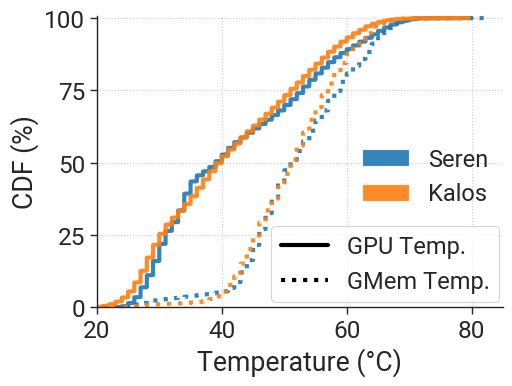

In [36]:
SAVEPKL = "../cluster_util/plot_pkl_zm"
month_select = 8
with open(f"{SAVEPKL}/gpu_temp_s{str(month_select)}.pkl", "rb") as file:
    x1, y1, x2, y2 = pickle.load(file)
with open(f"{SAVEPKL}/gpu_temp_k{str(month_select)}.pkl", "rb") as file:
    x1_k, y1_k, x2_k, y2_k = pickle.load(file)
with open(f"{SAVEPKL}/gpu_power_s{str(month_select)}.pkl", "rb") as file:
    x3, y3 = pickle.load(file)
with open(f"{SAVEPKL}/gpu_power_k{str(month_select)}.pkl", "rb") as file:
    x3_k, y3_k = pickle.load(file)

linestyles = ["-", ":", ":", "-"]
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5, 3.75))

############ Fig 1: Temperature ############
ax1.plot(x1, y1, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren GPU Temp")
ax1.plot(x2, y2, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="Seren GPU Mem Temp")
ax1.plot(x1_k, y1_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos GPU Temp")
ax1.plot(x2_k, y2_k, linestyles[1], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos GPU Mem Temp")

ax1.set_xlabel(f"Temperature (°C)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xlim(20, 85)
ax1.set_ylim(0, 100.8)
# ax1.legend(
#     loc="lower right",
#     # bbox_to_anchor=(0.5, 1.4),
#     # ncol=2,
#     fancybox=False,
#     shadow=False,
#     fontsize=14)
ax1.grid(linestyle=":")

S = mpatches.Patch(facecolor=cmp[0], alpha=0.9)  # , edgecolor="black"
K = mpatches.Patch(facecolor=cmp[1], alpha=0.9)
A = (Line2D([0], [0], color="black", lw=3, ls="-"),)
B = (Line2D([0], [0], color="black", lw=3, ls=":"),)

legend1 = ax1.legend([S, K], ["Seren", "Kalos"], bbox_to_anchor=(0.6, 0.62), loc=2, ncol=1, fontsize=17, frameon=False)

ax1.add_artist(legend1)

ax1.legend(
    [A, B],
    ["GPU Temp.", "GMem Temp."],
    bbox_to_anchor=(0.4, 0.32),
    loc=2,
    ncol=1,
    fontsize=17,
)

sns.despine()
fig.savefig(f"{SAVEPATH}/cdf_temperature.pdf", bbox_inches="tight")

#### CDF: Power

In [2]:
df_AB = pd.read_csv("../ipmi/csv/GPU_AB_Power.csv", parse_dates=["Time"])
df_C = pd.read_csv("../ipmi/csv/GPU_C_Power.csv", parse_dates=["Time"])
df_D = pd.read_csv("../ipmi/csv/GPU_D_Power.csv", parse_dates=["Time"])

df_A = df_AB.dropna()
df_B = df_AB[df_AB.isna().any(axis=1)]  # Type B without MEM_Power record

dfs = {"GPU_A": df_A, "GPU_B": df_B, "GPU_C": df_C, "CPU_D": df_D}

# Extract sys_total_power
df_A_power = df_A[["Time", "Sys_Total_Power"]]
df_B_power = df_B[["Time", "Sys_Total_Power"]]
df_C_power = df_C[["Time", "Sys_Total_Power"]]
df_gpu = pd.concat([df_A_power, df_B_power, df_C_power])

x1, y1 = calculate_sum_cdf_axis100(df_gpu)
x2, y2 = calculate_sum_cdf_axis100(df_D[["Time", "Sys_Total_Power"]])

/tmp/ipykernel_221007/3576474441.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_D = pd.read_csv("../ipmi/csv/GPU_D_Power.csv", parse_dates=["Time"])


Parsing
Parsing


In [3]:
SAVEPKL = "../cluster_util/plot_pkl_zm"
month_select = 8
with open(f"{SAVEPKL}/gpu_power_s5.pkl", "rb") as file:
    x3, y3 = pickle.load(file)
with open(f"{SAVEPKL}/gpu_power_k{str(month_select)}.pkl", "rb") as file:
    x3_k, y3_k = pickle.load(file)

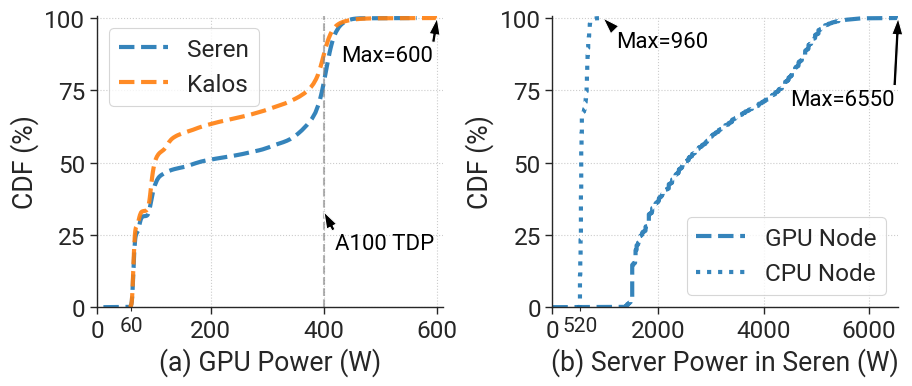

In [19]:
linestyles = ["--", ":", ":", "-"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

############ Fig 2: GPU power ############
ax1.plot(x3, y3, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="Seren")
ax1.plot(x3_k, y3_k, linestyles[0], linewidth=3, alpha=0.9, color=cmp[1], label="Kalos")
ax1.axvline(x=400, ls="--", alpha=0.6, c="gray", ymax=100, lw=1.5)
ax1.annotate(
    "A100 TDP",
    xy=(400, 33),
    xytext=(420, 20),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)
ax1.annotate(
    "Max=600",
    xy=(600, 100),
    xytext=(430, 85),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)
# ax1.annotate('Max=564', xy=(564, 100), xytext = (400, 70), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=16)

############ Fig 1: CDF ############
ax2.plot(x1, y1, linestyles[0], linewidth=3, alpha=0.9, color=cmp[0], label="GPU Node")
ax2.plot(x2, y2, linestyles[1], linewidth=3, alpha=0.9, color=cmp[0], label="CPU Node")
ax2.annotate(
    "Max=960",
    xy=(960, 100),
    xytext=(1200, 90),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)
ax2.annotate(
    "Max=6550",
    xy=(6550, 100),
    xytext=(4500, 70),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=16,
)


ax1.set_xlabel(f"(a) GPU Power (W)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xlim(-0.8, 610)
ax1.set_ylim(0, 100.8)
ax1.legend()
ax1.grid(linestyle=":")
ax1.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([60]))
ax1.xaxis.set_minor_formatter(matplotlib.ticker.FixedFormatter([60]))
ax1.tick_params(axis="x", which="minor", labelsize=15)

ax2.set_xlabel(f"(b) Server Power in Seren (W)")
ax2.set_ylabel(f"CDF (%)")
ax2.set_xlim(-0.8, x1.max())
ax2.set_ylim(0, 100.8)
ax2.legend(loc="lower right")
ax2.grid(linestyle=":")
ax2.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([520]))
ax2.xaxis.set_minor_formatter(matplotlib.ticker.FixedFormatter([520]))
ax2.tick_params(axis="x", which="minor", labelsize=15)
sns.despine()

fig.savefig(f"{SAVEPATH}/cdf_power.pdf", bbox_inches="tight")

In [22]:
np.mean(x1) / np.mean(x2)

5.044515466331751

In [21]:
np.mean(x2)

580.9043543543543

In [17]:
np.percentile(x3, 77.9)

400.0221

#### Month Util Trend

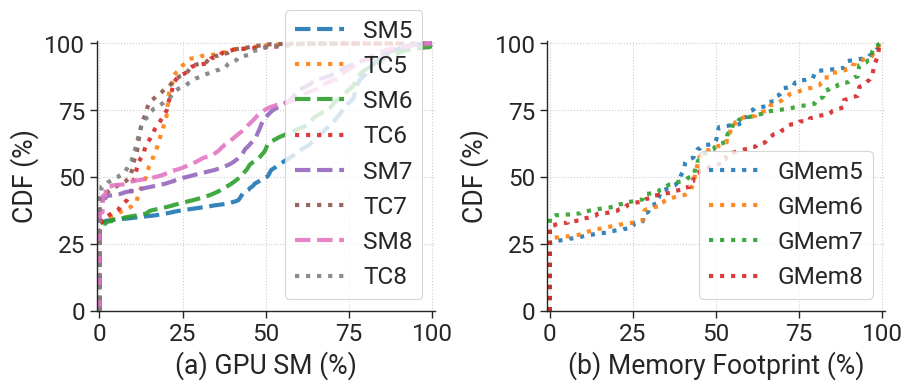

In [66]:
linestyles = ["--", ":", "--", "-.", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))

for m in [5, 6, 7, 8]:
    with open(f"../cluster_util/plot_pkl_zm/util_gpu_s{m}.pkl", "rb") as file:
        x1, y1, x2, y2, x3, y3, x4, y4, x5, y5 = pickle.load(file)

    ############ Fig 1: SM, Occupancy ############
    ax1.plot(x3, y3, linestyles[0], linewidth=3, alpha=0.9, label=f"SM{m}")  # Activity
    ax1.plot(x5, y5, linestyles[1], linewidth=3, alpha=0.9, label=f"TC{m}")  # Pipe Tensor

    ############ Fig 2: CPU mem usage, GPU mem usage ############
    ax2.plot(x2, y2, linestyles[1], linewidth=3, alpha=0.9, label=f"GMem{m}")


ax1.set_xlabel(f"(a) GPU SM (%)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_xlim(-0.8, 100.8)
ax1.set_ylim(0, 100.8)
ax1.set_xticks([0, 25, 50, 75, 100])
ax1.legend(loc="lower right")
ax1.grid(linestyle=":")

ax2.set_xlabel(f"(b) Memory Footprint (%)")
ax2.set_ylabel(f"CDF (%)")
ax2.set_xlim(-0.8, 100.8)
ax2.set_xticks([0, 25, 50, 75, 100])
ax2.set_ylim(0, 100.8)
ax2.legend(loc="lower right")
ax2.grid(linestyle=":")

sns.despine()

fig.savefig(f"{SAVEPATH}/cdf_monthly_resource_util.pdf", bbox_inches="tight")

#### Plot: I/O for Eval System

In [18]:
df

,1,8,32,64,128,256,512,1024
HWFS,2007.1070,808.2118,870.5966,774.3302,743.5146,732.4794,701.0776,609.0816
Boto3 HDD,425.5744,348.0158,350.3250,354.6948,350.3250,351.7874,268.5876,132.0946
PCIe,2390.3510,1714.3770,1714.3770,1714.3770,1714.3770,1714.3770,1714.3770,1714.3770


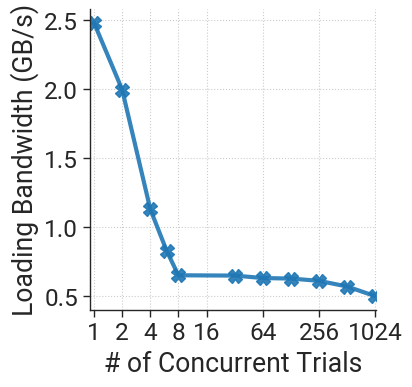

In [206]:
linestyles = ["-", ":", "--", "-.", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4, 3.75))

df = pd.read_csv("./csv/sys_load_MBps.csv", index_col=0)
df.dropna(axis=1, how="all", inplace=True)
df = df / 1024

x1 = [int(col) for col in df.columns.to_list()]

ax1.plot(x1, df.iloc[0], "-X", linewidth=3, alpha=0.9, label=f"HWFS")  # HWFS
# ax1.plot(x1, df.iloc[1], linestyles[1], linewidth=3, alpha=0.9, label=f"HWFS")
# ax1.plot(x1, df.iloc[2], linestyles[1], linewidth=3, alpha=0.9, label=f"HWFS")

ax1.set_xlabel(f"# of Concurrent Trials")
ax1.set_ylabel(f"Loading Bandwidth (GB/s)")
ax1.set_xscale("log", base=2)
ax1.set_xticks([2**i for i in [0, 1, 2, 3, 4, 6, 8, 10]])
ax1.set_xticklabels([2**i for i in [0, 1, 2, 3, 4, 6, 8, 10]])
ax1.set_xlim(0.9, 1030)
# ax1.set_ylim(0, 100.8)
# ax1.set_xticks([0, 25, 50, 75, 100])
# ax1.legend(loc="lower right")
ax1.grid(linestyle=":")
sns.despine()

# ax1.text(0.015, 0.03, "Seren", transform=ax1.transAxes, size=18,fontweight='bold')
fig.savefig(f"{SAVEPATH}/plot_sys_eval_io.svg", bbox_inches="tight")

#### Bar: Pretraining System Performance

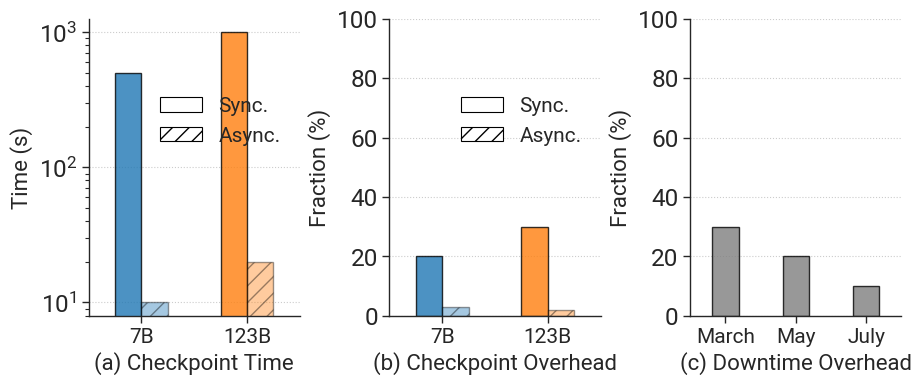

In [41]:
grid_params = dict(width_ratios=[1, 1, 1])
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(9, 3.75))


x = np.arange(1, 3)
width = 0.25
error_params = dict(elinewidth=2, ecolor="k", capsize=3)
ax1.bar(x - width / 2, [500, 1000], width=width, label="Sync.", alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[0], cmp[1]])
ax1.bar(
    x + width / 2,
    [10, 20],
    width=width,
    label="Async.",
    alpha=0.4,
    linewidth=1,
    edgecolor="k",
    color=[cmp[0], cmp[1]],
    hatch="//",
)

ax1.set_xlabel(f"(a) Checkpoint Time", size=16)
ax1.set_ylabel(f"Time (s)", size=16)
ax1.set_xticks(x)
ax1.set_xticklabels(["7B", "123B"], size=15)
ax1.set_xlim(0.5, 2.5)
ax1.grid(axis="y", linestyle=":")
ax1.set_yscale("log")

A = mpatches.Patch(facecolor="white", edgecolor="black", label="Sync.")
B = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Async.")
ax1.legend(
    handles=[A, B],
    bbox_to_anchor=(0.25, 0.8),
    loc=2,
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=15,
)

ax2.bar(x - width / 2, [20, 30], width=width, label="Sync.", alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[0], cmp[1]])
ax2.bar(
    x + width / 2,
    [3, 2],
    width=width,
    label="Async.",
    alpha=0.4,
    linewidth=1,
    edgecolor="k",
    color=[cmp[0], cmp[1]],
    hatch="//",
)

ax2.set_xlabel(f"(b) Checkpoint Overhead", size=16)
ax2.set_ylabel(f"Fraction (%)", size=16)
ax2.set_xticks(x)
ax2.set_xticklabels(["7B", "123B"], size=15)
ax2.set_xlim(0.5, 2.5)
ax2.set_ylim(0, 100)
ax2.grid(axis="y", linestyle=":")
# ax2.set_yscale("log")

A = mpatches.Patch(facecolor="white", edgecolor="black", label="Sync.")
B = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Async.")
ax2.legend(
    handles=[A, B],
    bbox_to_anchor=(0.25, 0.8),
    loc=2,
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=15,
)

x = np.arange(1, 4)
ax3.bar(x, [30, 20, 10], width=width * 1.5, label="Downtime", alpha=0.8, linewidth=1, edgecolor="k", color=cmp[-3])

ax3.set_xlabel(f"(c) Downtime Overhead", size=16)
ax3.set_ylabel(f"Fraction (%)", size=16)
ax3.set_xticks(x)
ax3.set_xticklabels(["March", "May", "July"], size=15)
ax3.set_xlim(0.5, 3.5)
ax3.set_ylim(0, 100)
ax3.grid(axis="y", linestyle=":")
# ax2.set_yscale("log")

sns.despine()

fig.savefig(f"{SAVEPATH}/bar_pretrain_sys_performance.pdf", bbox_inches="tight")

#### Bar: System Prof

/tmp/ipykernel_31782/137648776.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 1000)


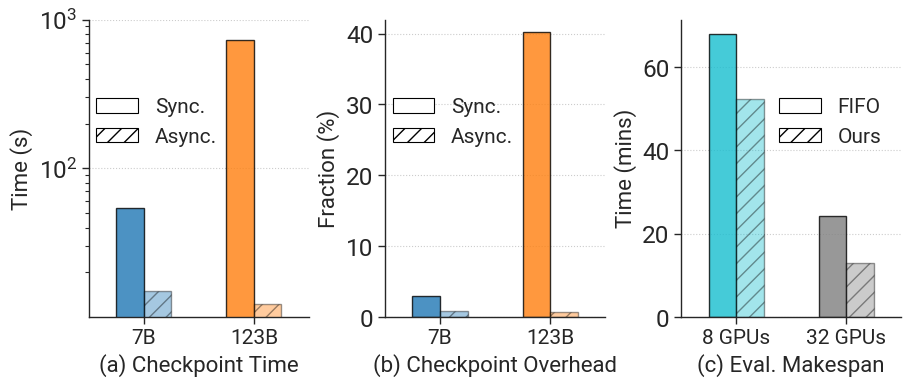

In [201]:
grid_params = dict(width_ratios=[1, 1, 1])
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(9, 3.75))


x = np.arange(1, 3)
width = 0.25
error_params = dict(elinewidth=2, ecolor="k", capsize=3)
ax1.bar(x - width / 2, [54, 723], width=width, label="Sync.", alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[0], cmp[1]])
ax1.bar(
    x + width / 2,
    [15.12, 12.32],
    width=width,
    label="Async.",
    alpha=0.4,
    linewidth=1,
    edgecolor="k",
    color=[cmp[0], cmp[1]],
    hatch="//",
)

ax1.set_xlabel(f"(a) Checkpoint Time", size=16)
ax1.set_ylabel(f"Time (s)", size=16)
ax1.set_xticks(x)
ax1.set_xticklabels(["7B", "123B"], size=15)
ax1.set_xlim(0.5, 2.5)
ax1.set_yscale("log")

ax1.set_ylim(0, 1000)
ax1.grid(axis="y", linestyle=":")

A = mpatches.Patch(facecolor="white", edgecolor="black", label="Sync.")
B = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Async.")
ax1.legend(
    handles=[A, B],
    bbox_to_anchor=(-0.05, 0.8),
    loc=2,
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=15,
)

ax2.bar(x - width / 2, [3, 40.17], width=width, label="Sync.", alpha=0.8, linewidth=1, edgecolor="k", color=[cmp[0], cmp[1]])
ax2.bar(
    x + width / 2,
    [0.84, 0.68],
    width=width,
    label="Async.",
    alpha=0.4,
    linewidth=1,
    edgecolor="k",
    color=[cmp[0], cmp[1]],
    hatch="//",
)

ax2.set_xlabel(f"(b) Checkpoint Overhead", size=16)
ax2.set_ylabel(f"Fraction (%)", size=16)
ax2.set_xticks(x)
ax2.set_xticklabels(["7B", "123B"], size=15)
ax2.set_xlim(0.5, 2.5)
ax2.set_ylim(0, 42)
ax2.grid(axis="y", linestyle=":")
# ax2.set_yscale("log")

A = mpatches.Patch(facecolor="white", edgecolor="black", label="Sync.")
B = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Async.")
ax2.legend(
    handles=[A, B],
    bbox_to_anchor=(-0.05, 0.8),
    loc=2,
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=15,
)


ax3.bar(
    x - width / 2,
    [i / 60 for i in [4080, 1452]],
    width=width,
    label="8GPU",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
    color=[cmp[-1], cmp[-3]],
)
ax3.bar(
    x + width / 2,
    [i / 60 for i in [3134, 783]],
    width=width,
    label="32GPU",
    alpha=0.4,
    linewidth=1,
    edgecolor="k",
    color=[cmp[-1], cmp[-3]],
    hatch="//",
)


ax3.set_xlabel(f"(c) Eval. Makespan", size=16)
ax3.set_ylabel(f"Time (mins)", size=16)
ax3.set_xticks(x)
ax3.set_xticklabels(["8 GPUs", "32 GPUs"], size=15)
ax3.set_xlim(0.5, 2.5)
ax3.set_ylim(0)
ax3.grid(axis="y", linestyle=":")
# ax2.set_yscale("log")

A = mpatches.Patch(facecolor="white", edgecolor="black", label="FIFO")
B = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Ours")
ax3.legend(
    handles=[A, B],
    bbox_to_anchor=(0.36, 0.8),
    loc=2,
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=15,
)


sns.despine()

fig.savefig(f"{SAVEPATH}/bar_sys_performance.pdf", bbox_inches="tight")

#### Bar: Eval System Ablation

In [ ]:
import warnings

warnings.filterwarnings("ignore")
params = {"mathtext.fontset": "cm"}
plt.rcParams.update(params)


def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height + 0.2),
            xytext=(0, 5),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=14,
        )


# def trace_analysis(save=False):
cmp = sns.color_palette("tab10")
grid_params = dict(width_ratios=[1, 1.2])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

# prepocess data
nof_ray_time = np.array([30305, 71425])
nof_time = np.array([28649, 65522])
intra_time = np.array([3028, 4762])
nof_hydro_time = np.array([2804, 4409])

nos_time = np.array([17232, 34446])
nos_s2_time = np.array([9755, 19118])
nos_s4_time = np.array([5362, 7373])
nos_hydro_time = np.array([2804, 4409])
nos_s16_time = np.array([2204, 2531])

xtickname = ["VGG-11", "ResNet-18"]
y_ticks = np.arange(1, 17, 2)
x = np.arange(1, 5)
x1 = np.arange(1, 3)
width = 0.14

ax1.bar(x1 - width * 1.5, nof_ray_time / 3600, width=width, label="Ray", alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0])
ax1.bar(
    x1 - width * 0.5,
    nof_time / 3600,
    width=width,
    label="Hydro w/o inter-fusion",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
    color=cmp[1],
)
ax1.bar(
    x1 + width * 0.5,
    intra_time / 3600,
    width=width,
    label="Hydro w/o intra-fusion",
    alpha=0.8,
    linewidth=1,
    edgecolor="k",
    color=cmp[3],
)
ax1.bar(
    x1 + width * 1.5, nof_hydro_time / 3600, width=width, label="Hydro", alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2]
)

width = 0.12
x2 = np.arange(1, 3)
ax2.bar(
    x2 - width * 2, nos_time / 3600, width=width, label="Hydro w/o scaling", alpha=0.8, linewidth=1, edgecolor="k", color=cmp[0]
)
ax2.bar(x2 - width, nos_s2_time / 3600, width=width, label="Hydro s=2", alpha=0.8, linewidth=1, edgecolor="k", color=cmp[1])
ax2.bar(x2, nos_s4_time / 3600, width=width, label="Hydro s=4", alpha=0.8, linewidth=1, edgecolor="k", color=cmp[3])
ax2.bar(x2 + width, nos_hydro_time / 3600, width=width, label="Hydro", alpha=0.8, linewidth=1, edgecolor="k", color=cmp[2])
ax2.bar(
    x2 + width * 2, nos_s16_time / 3600, width=width, label="Hydro s=16", alpha=0.8, linewidth=1, edgecolor="k", color=cmp[4]
)

ax1.set_ylabel(f"Makespan (hours)")
ax1.set_xticks(x1)
ax2.set_xticks(x2)
ax1.set_xticklabels(xtickname)
ax2.set_xticklabels(xtickname)
ax1.set_xlim(0.5, 2.5)
ax2.set_xlim(0.5, 2.5)
# ax1.set_yticks(np.arange(1, 23, 3))
ax1.set_ylim(0, 20)
ax1.grid(axis="y", linestyle=":")

#### Profiling: Eval

In [4]:
file = "/mnt/petrelfs/share_data/wangguoteng.p/dcgmi/eval/7B/dcgmi_1ms_7B_1gpu_S_cluster.log"

# path = f'{DATA_PATH}/dcgmi/120B'
# file_list = os.listdir(path)
# file = file_list[0]

data = pd.read_csv(file, sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data.reset_index(drop=True, inplace=True)
df = data

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/petrelfs/share_data/wangguoteng.p/dcgmi/eval/7B/dcgmi_1ms_7B_1gpu_S_cluster.log'

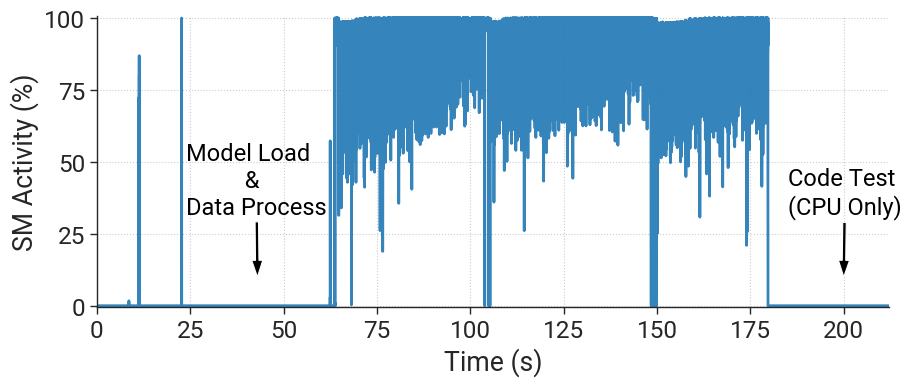

In [56]:
metric_list = df.columns
metric = metric_list[1]

# start = 7000
# end = 7800

start = 0
end = df.index[-1]

linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.75))

x = np.append(df.index.values[start:end], 212222)
y = np.append(df[df.columns[df.columns.str.contains(metric)]][start:end], 0)

ax1.plot(x, y * 100, linewidth=2, alpha=0.9)  # color=cmp[0], label=metric,

ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_xlim(0, x[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend()
ax1.grid(linestyle=":")
ax1.set_xticks(x[::25000])
ax1.set_xticklabels([int(i) for i in x[::25000] / 1000])

ax1.annotate(
    "Code Test\n(CPU Only)",
    xy=(200000, 10),
    xytext=(185000, 32),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=17,
)
ax1.annotate(
    "Model Load\n          &\nData Process",
    xy=(43000, 10),
    xytext=(24000, 32),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=17,
)
sns.despine()
# fig.savefig(f"{SAVEPATH}/profiling_eval.pdf", bbox_inches="tight")

#### Profiling: Pretraining

In [ ]:
path = f"/mnt/petrelfs/share_data/wangguoteng.p/dcgmi/pretrain/123B"
file_list = os.listdir(path)
file = file_list[4]
print(file)

data = pd.read_csv(f"{path}/{file}", sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data = data[data["#Entity"] == "GPU 0"]
data.reset_index(drop=True, inplace=True)
df = data

HOST-10-140-66-3


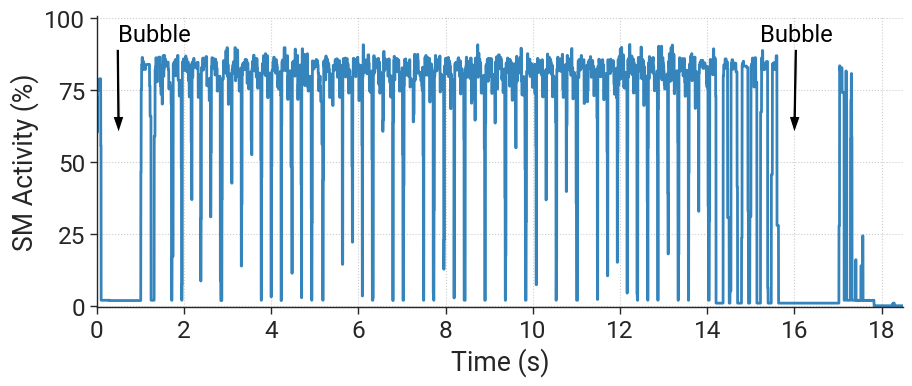

In [ ]:
df = data
metric_list = df.columns
metric = metric_list[1]

# start = 7000
# end = 7800

start = 0
end = df.index[-1800]

linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.75))

x = df.index.values[start:end]
y = df[df.columns[df.columns.str.contains(metric)]][start:end]  # .mean(axis=1)

ax1.plot(x, y * 100, linewidth=2, alpha=0.9)  # color=cmp[0], label=metric,


ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_xlim(0, x[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend()
ax1.grid(linestyle=":")
ax1.set_xticks(x[::2000])
ax1.set_xticklabels([int(i) for i in x[::2000] / 1000])

ax1.annotate(
    "Bubble",
    xy=(16000, 60),
    xytext=(15200, 92),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=17,
)
ax1.annotate(
    "Bubble",
    xy=(500, 60),
    xytext=(480, 92),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=17,
)
sns.despine()
fig.savefig(f"{SAVEPATH}/profiling_pretraining.pdf", bbox_inches="tight")

#### Profiling: Pretraining (2048)

###### Combined

In [2]:
file = f"../profile/sm_data/new_3D_2048_mtp_sm.data"
print(file)

data = pd.read_csv(file, sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data = data[data["#Entity"] == "GPU 0"]
data.reset_index(drop=True, inplace=True)
df_3d = data

file = f"../profile/sm_data/new_zero64_2048_sm.data"
print(file)

data = pd.read_csv(file, sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data = data[data["#Entity"] == "GPU 0"]
data.reset_index(drop=True, inplace=True)
df_zero = data

metric_list = df_zero.columns
metric = metric_list[1]

../profile/sm_data/new_3D_2048_mtp_sm.data
../profile/sm_data/new_zero64_2048_sm.data


In [6]:
df_3d

,#Entity,SMACT,SMOCC,TENSO,PCITX,PCIRX,GPUTL,FBUSD
0,GPU 0,0.839,0.271,0.525,397524539.0,3.072970e+09,100.0,66915.0
1,GPU 0,0.839,0.271,0.525,397524539.0,3.072970e+09,100.0,66915.0
2,GPU 0,0.839,0.271,0.525,397524539.0,3.072970e+09,100.0,66915.0
3,GPU 0,0.839,0.271,0.525,397524539.0,3.072970e+09,100.0,66915.0
4,GPU 0,0.839,0.271,0.525,397524539.0,3.072970e+09,100.0,66915.0
...,...,...,...,...,...,...,...,...
76154,GPU 0,0.726,0.215,0.468,148965244.0,1.135835e+09,98.0,67299.0
76155,GPU 0,0.726,0.215,0.468,148965244.0,1.135835e+09,98.0,67299.0
76156,GPU 0,0.758,0.194,0.531,156938150.0,1.257728e+09,98.0,67299.0
76157,GPU 0,0.758,0.194,0.531,156938150.0,1.257728e+09,98.0,67299.0


In [4]:
df_zero

,#Entity,SMACT,SMOCC,TENSO,PCITX,PCIRX,GPUTL,FBUSD
0,GPU 0,0.870,0.138,0.732,256461642.0,1.051212e+10,100.0,81053.0
1,GPU 0,0.870,0.138,0.732,256461642.0,1.051212e+10,100.0,81053.0
2,GPU 0,0.870,0.138,0.732,256461642.0,1.051212e+10,100.0,81053.0
3,GPU 0,0.514,0.102,0.395,166013208.0,1.233995e+10,100.0,81053.0
4,GPU 0,0.514,0.102,0.395,166013208.0,1.233995e+10,100.0,81053.0
...,...,...,...,...,...,...,...,...
96380,GPU 0,0.182,0.050,0.080,136940175.0,2.096786e+10,100.0,73495.0
96381,GPU 0,0.182,0.050,0.080,136940175.0,2.096786e+10,100.0,73495.0
96382,GPU 0,0.683,0.148,0.472,79441769.0,1.845269e+10,100.0,73495.0
96383,GPU 0,0.683,0.148,0.472,79441769.0,1.845269e+10,100.0,73495.0


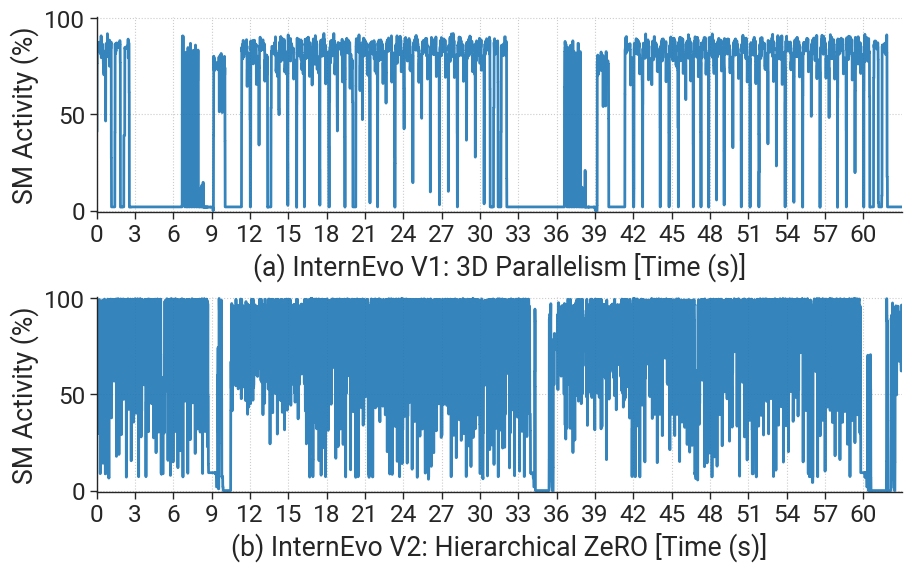

In [3]:
linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, figsize=(9, 5.6))

start = 27000
end = 69000

x3d = df_3d.index.values[start:end] - start
y3d = df_3d[df_3d.columns[df_3d.columns.str.contains(metric)]][start:end]  # .mean(axis=1)

ax1.plot(x3d, y3d * 100, linewidth=2, alpha=0.9)  # color=cmp[0], label=metric,

start_zero = 52000
end_zero = 94000

xzero = df_zero.index.values[start_zero:end_zero]
yzero = df_zero[df_zero.columns[df_zero.columns.str.contains(metric)]][start_zero:end_zero]  # .mean(axis=1)
# yzero.reset_index(inplace=True, drop=True)

ax2.plot(xzero, yzero.values * 100, linewidth=2, alpha=0.9)

ax1.set_xlabel(f"(a) InternEvo V1: 3D Parallelism [Time (s)]")
# ax1.set_xlabel(f"(a) Time (s): InternEVO")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_xlim(start, x3d[-1])
ax1.set_ylim(-0.5, 100.8)
ax1.grid(linestyle=":")
ax1.set_xticks(x3d[::2000])
ax1.set_xticklabels([int(i * 1.5) for i in x3d[::2000] / 1000])  # x1.5 because DCGM not precise

ax2.set_xlabel(f"(b) InternEvo V2: Hierarchical ZeRO [Time (s)]")
ax2.set_ylabel(f"SM Activity (%)")
ax2.set_xlim(start_zero, xzero[-1])
ax2.set_ylim(-0.5, 100.8)
ax2.grid(linestyle=":")
ax2.set_xticks(xzero[::2000])
ax2.set_xticklabels([int((i - start_zero / 1000) * 1.5) for i in xzero[::2000] / 1000])

# ax1.annotate('Bubble', xy=(16000, 60), xytext = (15200, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
# ax1.annotate('Bubble', xy=(500, 60), xytext = (480, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
sns.despine()
# fig.savefig(f"{SAVEPATH}/profiling_pretraining_2048.pdf", bbox_inches="tight")
fig.savefig(f"{SAVEPATH}/profiling_pretraining_2048.png", dpi=900, transparent=True, bbox_inches="tight")

#### Profiling: Pretraining (1024)

###### Combined

In [2]:
file = f"../profile/sm_data/log_123b_sm_3d_gpu8_mem_big.data"
print(file)

data = pd.read_csv(file, sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data = data[data["#Entity"] == "GPU 0"]
data.reset_index(drop=True, inplace=True)
df_3d = data

file = f"../profile/sm_data/log_123b_zero_wp64_sm.data"
print(file)

data = pd.read_csv(file, sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data = data[data["#Entity"] == "GPU 0"]
data.reset_index(drop=True, inplace=True)
df_zero = data

metric_list = df_zero.columns
metric = metric_list[1]

../profile/sm_data/log_123b_sm_3d_gpu8_mem_big.data


../profile/sm_data/log_123b_zero_wp64_sm.data


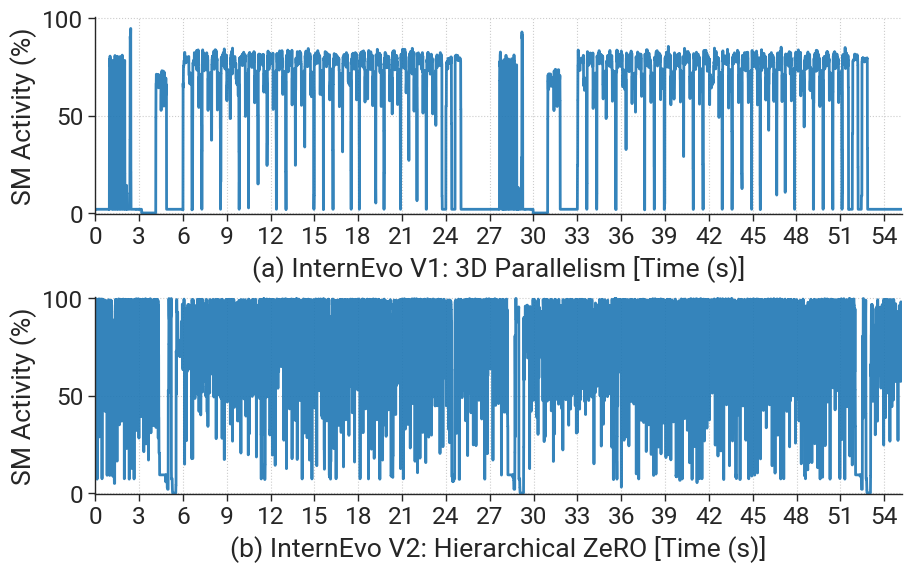

In [3]:
linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, figsize=(9, 5.6))

start = 3200
end = 40000

x3d = df_3d.index.values[start:end] - start
y3d = df_3d[df_3d.columns[df_3d.columns.str.contains(metric)]][start:end]  # .mean(axis=1)

ax1.plot(x3d, y3d * 100, linewidth=2, alpha=0.9)  # color=cmp[0], label=metric,

start_zero = 8100
end_zero = 58100

xzero = df_zero.index.values[start_zero:end_zero] - start_zero
yzero = df_zero[df_zero.columns[df_zero.columns.str.contains(metric)]][start_zero:end_zero]  # .mean(axis=1)

ax2.plot(xzero, yzero * 100, linewidth=2, alpha=0.9)

ax1.set_xlabel(f"(a) InternEvo V1: 3D Parallelism [Time (s)]")
# ax1.set_xlabel(f"(a) Time (s): InternEVO")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_xlim(start, x3d[-1])
ax1.set_ylim(-0.5, 100.8)
ax1.grid(linestyle=":")
ax1.set_xticks(x3d[::2000])
ax1.set_xticklabels([int(i * 1.5) for i in x3d[::2000] / 1000])  # x1.5 because DCGM not precise

ax2.set_xlabel(f"(b) InternEvo V2: Hierarchical ZeRO [Time (s)]")
ax2.set_ylabel(f"SM Activity (%)")
ax2.set_xlim(start_zero, xzero[-1])
ax2.set_ylim(-0.5, 100.8)
ax2.grid(linestyle=":")
ax2.set_xticks(xzero[::2000])
ax2.set_xticklabels([int(i * 1.5) for i in xzero[::2000] / 1000])

# ax1.annotate('Bubble', xy=(16000, 60), xytext = (15200, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
# ax1.annotate('Bubble', xy=(500, 60), xytext = (480, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
sns.despine()
fig.savefig(f"{SAVEPATH}/profiling_pretraining.pdf", bbox_inches="tight")

###### 123B 3D

In [11]:
file = f"../profile/sm_data/log_123b_sm_3d_gpu8_mem_big.data"
print(file)

data = pd.read_csv(file, sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data = data[data["#Entity"] == "GPU 0"]
data.reset_index(drop=True, inplace=True)
df = data

../profile/sm_data/log_123b_sm_3d_gpu8_mem_big.data


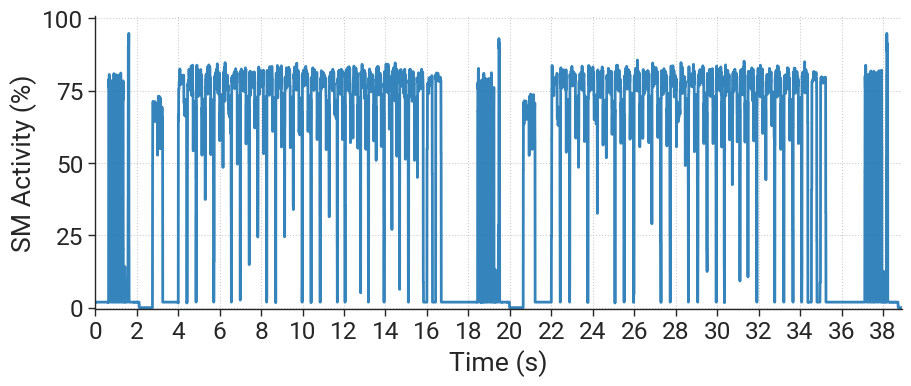

In [18]:
metric_list = df.columns
metric = metric_list[1]

# start = 7000
# end = 7800

start = 3200
end = 42100

linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.75))

x = df.index.values[start:end] - start
y = df[df.columns[df.columns.str.contains(metric)]][start:end]  # .mean(axis=1)

ax1.plot(x, y * 100, linewidth=2, alpha=0.9)  # color=cmp[0], label=metric,


ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_xlim(start, x[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend()
ax1.grid(linestyle=":")
ax1.set_xticks(x[::2000])
ax1.set_xticklabels([int(i) for i in x[::2000] / 1000])


# ax1.annotate('Bubble', xy=(16000, 60), xytext = (15200, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
# ax1.annotate('Bubble', xy=(500, 60), xytext = (480, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
sns.despine()
# fig.savefig(f"{SAVEPATH}/profiling_pretraining_moe.pdf", bbox_inches="tight")

###### 123B ZeRO

In [19]:
file = f"../profile/sm_data/log_123b_zero_wp64_sm.data"
print(file)

data = pd.read_csv(file, sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data = data[data["#Entity"] == "GPU 0"]
data.reset_index(drop=True, inplace=True)
df = data

../profile/sm_data/log_123b_zero_wp64_sm.data


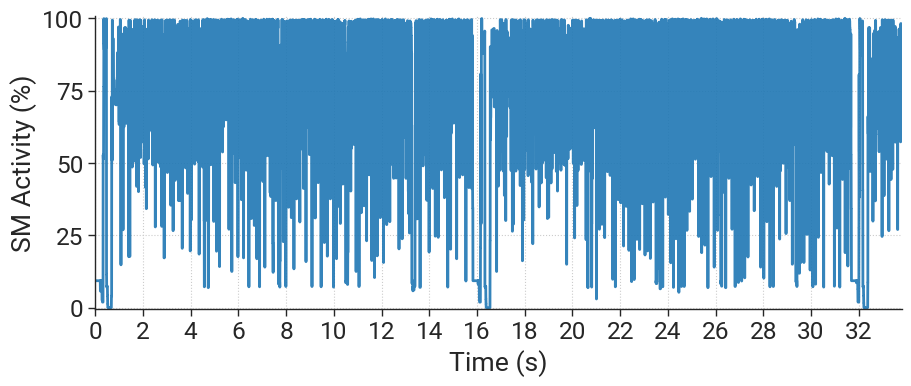

In [22]:
metric_list = df.columns
metric = metric_list[1]

# start = 7000
# end = 7800

start = 11100
end = 58100

linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.75))

x = df.index.values[start:end] - start
y = df[df.columns[df.columns.str.contains(metric)]][start:end]  # .mean(axis=1)

ax1.plot(x, y * 100, linewidth=2, alpha=0.9)  # color=cmp[0], label=metric,


ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_xlim(start, x[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend()
ax1.grid(linestyle=":")
ax1.set_xticks(x[::2000])
ax1.set_xticklabels([int(i) for i in x[::2000] / 1000])


# ax1.annotate('Bubble', xy=(16000, 60), xytext = (15200, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
# ax1.annotate('Bubble', xy=(500, 60), xytext = (480, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
sns.despine()
# fig.savefig(f"{SAVEPATH}/profiling_pretraining_moe.pdf", bbox_inches="tight")

###### 7B MoE

In [41]:
file = f"../profile/sm_data/log_moe_7b_sm.data"
print(file)

data = pd.read_csv(file, sep="\s\s+", engine="python")
data.dropna(axis=0, how="any", inplace=True)
cols = data.columns.drop("#Entity")
data[cols] = data[cols].apply(pd.to_numeric, errors="coerce")

data.dropna(axis=0, how="any", inplace=True)
data = data[data["#Entity"] == "GPU 0"]
data.reset_index(drop=True, inplace=True)
df = data

../profile/sm_data/log_moe_7b_sm.data


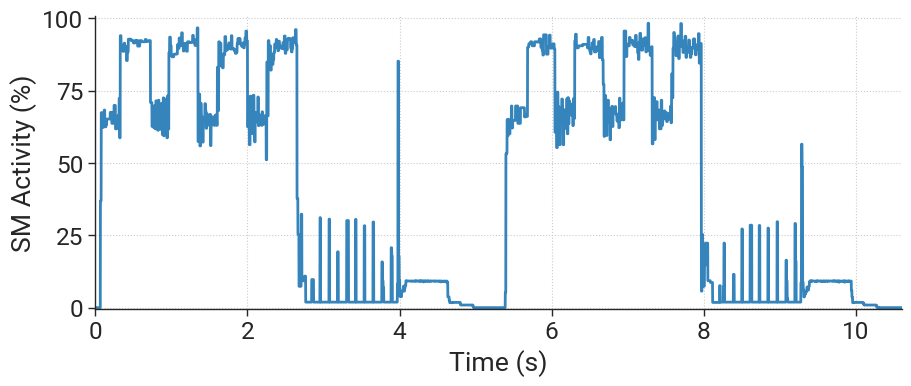

In [42]:
metric_list = df.columns
metric = metric_list[1]

# start = 7000
# end = 7800

start = 7500
end = 18100

linestyles = ["-", "--", ":", ":", ":"]
grid_params = dict(width_ratios=[1, 1])
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.75))

x = df.index.values[start:end] - start
y = df[df.columns[df.columns.str.contains(metric)]][start:end]  # .mean(axis=1)

ax1.plot(x, y * 100, linewidth=2, alpha=0.9)  # color=cmp[0], label=metric,


ax1.set_xlabel(f"Time (s)")
ax1.set_ylabel(f"SM Activity (%)")
ax1.set_xlim(start, x[-1])
ax1.set_ylim(-0.5, 100.8)
# ax1.legend()
ax1.grid(linestyle=":")
ax1.set_xticks(x[::2000])
ax1.set_xticklabels([int(i) for i in x[::2000] / 1000])


# ax1.annotate('Bubble', xy=(16000, 60), xytext = (15200, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
# ax1.annotate('Bubble', xy=(500, 60), xytext = (480, 92), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=17)
sns.despine()
fig.savefig(f"{SAVEPATH}/profiling_pretraining_moe.pdf", bbox_inches="tight")

#### Bar: Mem Breakdown

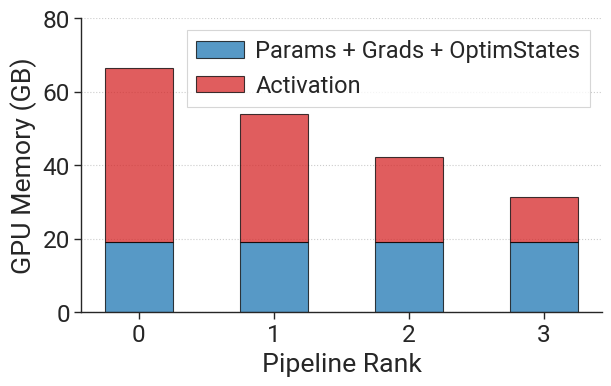

In [8]:
cmp = sns.color_palette("tab10")

fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 3.75))
# x_labels = ['Rank0', 'Rank8', 'Rank16', 'Rank24', 'Rank32', 'Rank40', 'Rank48', 'Rank56']
x = np.arange(0, 4)

width = 0.5
# labels = ['Params','Grads', 'OptimStates','Activation']
activation = [56.19, 43.69, 31.9, 21.1]

# params = 8.81
# grads = 8.81
# os_params = 1.5

labels = ["Params + Grads + OptimStates", "Activation"]
other = 8.81 + 1.5 + 8.81
activation = [i - 8.81 for i in activation]

A = ax.bar(x, other, width, edgecolor="k", label="Params", alpha=0.75, color=[cmp[0]])
# B = ax.bar(x, grads, width, bottom=params, edgecolor="k", label='Grads', alpha=0.75, color = [cmp[1]])
# C = ax.bar(x, os_params, width, bottom=np.array(params) + np.array(grads), edgecolor="k", label='OS Params', alpha=0.75, color = [cmp[2]])
D = ax.bar(x, activation, width, bottom=np.array(other), edgecolor="k", label="Activation", alpha=0.75, color=[cmp[3]])

ax.set_ylabel("GPU Memory (GB)")
ax.set_ylim(0, 80)
# ax.set_title('GraphSAGE, N=4')
ax.set_xlabel(f"Pipeline Rank")
ax.set_xticks(x)
# ax.set_xticklabels(x_labels, fontsize=12)
ax.grid(axis="y", linestyle=":")


ax.legend(
    labels,
    # loc="upper center",
    # handles=labels,
    # bbox_to_anchor=(0.5, 1.22),
    ncol=1,
    fancybox=False,
    shadow=False,
    fontsize=17,
    columnspacing=1,
    handletextpad=0.5,
)

sns.despine()

fig.savefig(f"{SAVEPATH}/profiling_activation_pp.pdf", bbox_inches="tight")

#### Plot: Failure Workloads

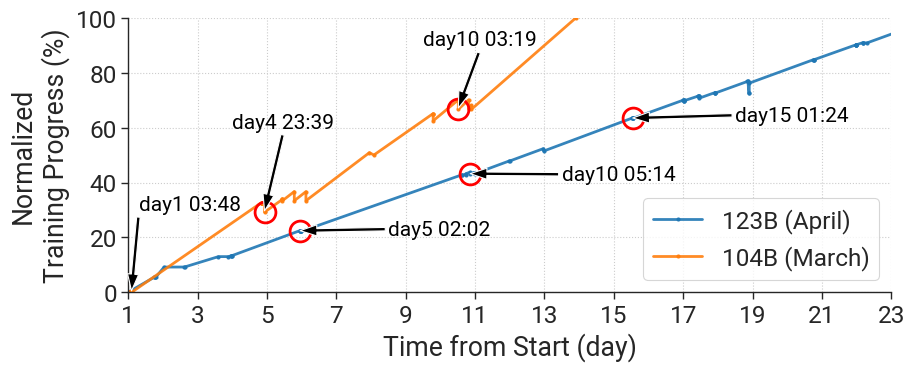

In [207]:
df1 = pd.read_csv(
    f"/mnt/petrelfs/share_data/wangzerui/llmtrace/llm_trace_collection/llm_job_logs/result/trace_of_each_job/630_v2.csv",
    index_col=False,
)[:49]
df2 = pd.read_csv(
    f"/mnt/petrelfs/share_data/wangzerui/llmtrace/llm_trace_collection/llm_job_logs/result/trace_of_each_job/1005.csv",
    index_col=False,
)[:60]

legend = []
dfs = [df1, df2]
# df.loc[df['start'] == 35.0, 'start'] = 2530
# df.loc[df['end'] == 35.0, 'end'] = 2200
for df in dfs:
    df["time_end"] = pd.to_datetime(df["time_end"])
    df["time_start"] = pd.to_datetime(df["time_start"])
import numpy as np


def get_xy(df):
    xs = []
    ys = []

    def merge_start_ends(job):
        xs.append(job["time_start"])
        xs.append(job["time_end"])
        ys.append(job["start"])
        ys.append(job["end"])

    df.apply(merge_start_ends, axis=1)
    xs_time = [item - xs[0] for item in xs]
    xs = [item.total_seconds() / 3600 for item in xs_time]
    max_y = max(ys)
    ys = [(item - ys[0]) / max_y for item in ys]
    # ys = [item * 100 for item in ys]
    return xs, ys


linestyles = ["-", "-", ":", "-"]
grid_params = dict(width_ratios=[1, 1])
fig, (ax1) = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(9, 3.6))

max_x = 0

for idx, df in enumerate(dfs):
    xs, ys = get_xy(df)
    max_x = max(xs) if max(xs) > max_x else max_x
    ax1.plot(xs, ys, marker=".", markersize=4, linewidth=2, alpha=0.9, linestyle=linestyles[idx])

    # for id in ids:
    #     d = df.loc[df['id_job'] == 5894921]

ax1.set_xlabel(f"Time from Start (day)")
ax1.set_ylabel(f"Normalized\nTraining Progress (%)")
# plt.xticks(np.arange(0, max_x, 24))
ax1.set_xlim(0, 26)
ax1.set_ylim(0, 1)
ax1.set_yticks(np.arange(0, 1.1, 0.2))
ax1.set_yticklabels(np.arange(0, 110, 20))
ax1.legend(["123B (April)", "104B (March)"], loc="lower right")
ax1.grid(linestyle=":")
ax1.set_xticks(np.arange(0, max_x, 48))
# ax1.set_yticklabels(np.arange(0, 110, 20))
ax1.set_xticklabels([str(int(x) + 1) for x in np.arange(0, 24, 2)])


d1 = df.loc[df["id_job"] == 5894921]
x1, y1 = xs[d1.index[0] * 2 - 1], ys[d1.index[0] * 2 - 1]
d2 = df.loc[df["id_job"] == 5927199]
x2, y2 = xs[d2.index[0] * 2], ys[d2.index[0] * 2]
# # d3 = df.loc[df['id_job'] == 5928306]
# # x3, y3 = xs[d3.index[0]*2 - 1], ys[d3.index[0]*2 - 1]
d4 = df.loc[df["id_job"] == 5930311]
x4, y4 = xs[d4.index[0] + df.shape[0] + 1], ys[d4.index[0] + df.shape[0] + 1]

# ax1.plot(x1, y1, marker='o', mec='r', mfc='none')
ax1.plot(x2, y2, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
# # # ax1.plot(x3, y3, marker='o', mec='r', mfc='none')
ax1.plot(x4, y4, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
ax1.annotate(
    "day1 03:48",
    xy=(x1, y1 + 0.005),
    xytext=(0.3 * 24, 0.3),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
ax1.annotate(
    "day4 23:39",
    xy=(x2, y2 + 0.005),
    xytext=(3 * 24, 0.6),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# # # ax1.annotate('Day6, 00:13 AM', xy=(x3, y3), xytext = (x3-30, y3-1500), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), color='black', fontsize=15)
ax1.annotate(
    "day10 03:19",
    xy=(x4, y4 + 0.005),
    xytext=(8.5 * 24, 0.9),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# # plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

ax1.plot(236.594722, 0.432318, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
ax1.annotate(
    "day10 05:14",
    xy=(236.5947220, 0.432318),
    xytext=(12.5 * 24, 0.41),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# ax2.plot

ax1.plot(118.930278, 0.224321, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
ax1.annotate(
    "day5 02:02",
    xy=(118.930278, 0.224321),
    xytext=(7.5 * 24, 0.21),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# ax2.plot

ax1.plot(349.086111, 0.635363, marker="o", mec="r", mfc="none", markersize=15, markeredgewidth=2)
ax1.annotate(
    "day15 01:24",
    xy=(349.086111, 0.635363),
    xytext=(17.5 * 24, 0.625363),
    arrowprops=dict(facecolor="black", width=2.5, headwidth=8),
    color="black",
    fontsize=15,
)
# ax1.annotate()
# ax1.text(0.015, 0.03, "Seren", transform=ax1.transAxes, size=18,fontweight='bold')


sns.despine()
fig.savefig(f"{SAVEPATH}/failure_example.pdf", bbox_inches="tight")

In [174]:
max_x

558.5641666666667

#### Plot: Mem Trace

In [48]:
with open(f"../profile/gpu_mem/123b_zero_parallel_mm_wp64_123b_ckpt_1.pickle", "rb") as file:
    data = pickle.load(file)

In [49]:
for key in data:
    print(key)

segments
device_traces


In [59]:
data["segments"][-1]

{'device': 0,
 'address': 139916396724224,
 'total_size': 2097152,
 'allocated_size': 906752,
 'active_size': 906752,
 'requested_size': 875249,
 'stream': 0,
 'segment_type': 'small',
 'segment_pool_id': (0, 0),
 'is_expandable': False,
 'frames': [],
 'blocks': [{'address': 139916396724224,
   'size': 512,
   'requested_size': 1,
   'state': 'active_allocated',
   'frames': []},
  {'address': 139916396724736,
   'size': 512,
   'requested_size': 4,
   'state': 'active_allocated',
   'frames': []},
  {'address': 139916396725248,
   'size': 512,
   'requested_size': 4,
   'state': 'active_allocated',
   'frames': []},
  {'address': 139916396725760,
   'size': 512,
   'requested_size': 256,
   'state': 'active_allocated',
   'frames': []},
  {'address': 139916396726272,
   'size': 512,
   'requested_size': 4,
   'state': 'active_allocated',
   'frames': []},
  {'address': 139916396726784,
   'size': 512,
   'requested_size': 4,
   'state': 'active_allocated',
   'frames': []},
  {'addre

In [56]:
len(data["segments"])

5

In [52]:
len((data["device_traces"][0][0]))

5

In [54]:
data["device_traces"][0][0]

{'action': 'alloc',
 'addr': 139916397674496,
 'size': 32768,
 'stream': 0,
 'frames': [{'name': 'torch::unwind::unwind()', 'filename': '??', 'line': 0},
  {'name': 'torch::CapturedTraceback::gather(bool, bool, bool)',
   'filename': '??',
   'line': 0},
  {'name': 'torch::cuda::(anonymous namespace)::gather_with_cpp()',
   'filename': 'memory_snapshot.cpp',
   'line': 0},
  {'name': 'c10::cuda::CUDACachingAllocator::Native::DeviceCachingAllocator::malloc(int, unsigned long, CUstream_st*)',
   'filename': 'CUDACachingAllocator.cpp',
   'line': 0},
  {'name': 'c10::cuda::CUDACachingAllocator::Native::NativeCachingAllocator::malloc(void**, int, unsigned long, CUstream_st*)',
   'filename': '',
   'line': 0},
  {'name': 'c10::cuda::CUDACachingAllocator::Native::NativeCachingAllocator::allocate(unsigned long) const',
   'filename': '',
   'line': 0},
  {'name': 'at::TensorBase at::detail::_empty_strided_generic<c10::ArrayRef<long> >(c10::ArrayRef<long>, c10::ArrayRef<long>, c10::Allocator*

#### Misc

In [29]:
df = pd.read_csv("./csv/cluster_summary.csv", index_col="id")
df

,job_num,cpu_job_num,gpu_job_num,avg_run_time_gpu,avg_que_time_gpu,avg_gpu_num,med_run_time_gpu,med_que_time_gpu,med_gpu_num,complete_rate_gpu,cancel_rate_gpu,fail_rate_gpu,complete_gpu_time,cancel_gpu_time,fail_gpu_time,complete_rate_gpu_time,cancel_rate_gpu_time,fail_rate_gpu_time,avg_run_time_cpu,avg_que_time_cpu,med_run_time_cpu,med_que_time_cpu,complete_rate_cpu,cancel_rate_cpu,fail_rate_cpu
id,,,,,,,,,,,,,,,,,,,,,,,,,
Seren,1031550,367737,663813,1414.335,445.984,5.680,122.000,1.0,1.0,0.497,0.075,0.429,4.560593e+09,1.427458e+10,2.675447e+09,0.212,0.664,0.124,733.894,4.813,14.0,1.0,0.858,0.039,0.102
Kalos,62413,42506,19907,1259.689,214.179,26.770,124.000,17.0,1.0,0.541,0.062,0.397,1.667685e+09,3.239202e+09,4.262929e+08,0.313,0.607,0.080,118.352,88.401,22.0,9.0,0.860,0.001,0.140
Philly,112956,0,112956,18006.055,3760.604,1.928,874.000,189.0,1.0,0.604,0.090,0.305,2.210176e+09,2.025326e+09,2.659215e+09,0.321,0.294,0.386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Helios,3362981,1782517,1580464,6651.681,862.047,3.716,206.000,0.0,1.0,0.624,0.221,0.155,3.999430e+10,3.071511e+10,7.288335e+09,0.513,0.394,0.093,628.759,73.907,2.0,0.0,0.909,0.030,0.061
PAI,1260920,0,1037085,4787.109,401.742,0.683,480.667,9.0,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Sum of Power consumption

In [79]:
df_AB = pd.read_csv("../ipmi/csv/GPU_AB_Power.csv", parse_dates=["Time"])
df_C = pd.read_csv("../ipmi/csv/GPU_C_Power.csv", parse_dates=["Time"])
df_D = pd.read_csv("../ipmi/csv/GPU_D_Power.csv", parse_dates=["Time"])

df_A = df_AB.dropna()
df_B = df_AB[df_AB.isna().any(axis=1)]  # Type B without MEM_Power record

# df_A/B/C: month-5/6/7/8
# df_D: month-5/6


# 改写存在中文日期的行
def rewrite_date(date_str):
    # 匹配的格式字符串，用于解析日期时间
    date_str = date_str[:16] + date_str[17:]
    format_str = "%Y年 %m月 %d日 星期 %H:%M:%S %Z"

    # 解析日期时间字符串为 datetime 对象
    date_time_obj = datetime.strptime(date_str, format_str)

    # 格式化为只包含数字的时间字符串
    time_str = date_time_obj.strftime("%Y-%m-%d %H:%M:%S")

    return time_str


# 直接删掉包含中文日期的
df_A = df_A[~df_A["Time"].map(lambda x: any(["\u4e00" <= i <= "\u9fff" for i in str(x)]))]
df_A["Time"] = pd.to_datetime(df_A["Time"]).dt.tz_convert("Asia/Shanghai")

df_B = df_B[~df_B["Time"].map(lambda x: any(["\u4e00" <= i <= "\u9fff" for i in str(x)]))]
df_B["Time"] = pd.to_datetime(df_B["Time"]).dt.tz_convert("Asia/Shanghai")

df_C = df_C[~df_C["Time"].map(lambda x: any(["\u4e00" <= i <= "\u9fff" for i in str(x)]))]
df_C["Time"] = pd.to_datetime(df_C["Time"]).dt.tz_convert("Asia/Shanghai")

df_D = df_D[~df_D["Time"].map(lambda x: any(["\u4e00" <= i <= "\u9fff" for i in str(x)]))]
df_D["Time"] = pd.to_datetime(df_D["Time"]).dt.tz_convert("Asia/Shanghai")

df_gpu = pd.concat([df_A, df_B, df_C])

/tmp/ipykernel_49486/1777447451.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_D = pd.read_csv("../ipmi/csv/GPU_D_Power.csv", parse_dates=["Time"])


In [87]:
# 按月份， 5， 6， 7， 8
month_list = [5, 6, 7, 8]
for m in month_list:
    start_date = datetime(2023, m, 1, 0, 0, 0).strftime("%Y-%m-%d %H:%M:%S")
    if m == 6:
        end_date = datetime(2023, m, 30, 23, 59, 59).strftime("%Y-%m-%d %H:%M:%S")
    else:
        end_date = datetime(2023, m, 31, 23, 59, 59).strftime("%Y-%m-%d %H:%M:%S")
    data_gpu_monthly = df_gpu[(df_gpu["Time"] >= start_date) & (df_gpu["Time"] < end_date)]
    sys_total_power = data_gpu_monthly["Sys_Total_Power"].mean()
    print(f"GPU Sys_total_power Mean in month-{m}: {sys_total_power: .3f}")
    print("*" * 50)

month_list = [5, 6]
for m in month_list:
    start_date = datetime(2023, m, 1, 0, 0, 0).strftime("%Y-%m-%d %H:%M:%S")
    if m == 6:
        end_date = datetime(2023, m, 30, 23, 59, 59).strftime("%Y-%m-%d %H:%M:%S")
    else:
        end_date = datetime(2023, m, 31, 23, 59, 59).strftime("%Y-%m-%d %H:%M:%S")
    data_cpu_monthly = df_D[(df_D["Time"] >= start_date) & (df_D["Time"] < end_date)]
    sys_total_power = data_cpu_monthly["Sys_Total_Power"].mean()
    print(f"CPU Sys_total_power in month-{m}: {sys_total_power: .3f}")
    print("*" * 50)

GPU Sys_total_power Mean in month-5:  3137.129
**************************************************
GPU Sys_total_power Mean in month-6:  3002.776
**************************************************
GPU Sys_total_power Mean in month-7:  2826.779
**************************************************
GPU Sys_total_power Mean in month-8:  2671.248
**************************************************
CPU Sys_total_power in month-5:  543.786
**************************************************
CPU Sys_total_power in month-6:  594.902
**************************************************


In [86]:
len(df_D["node"].unique())

6

In [84]:
len(df_gpu["node"].unique())

282

In [1]:
(286 * 3153 + 6 * 543) * 24 * 31 * 1.25 / 1e6

841.66488

#### Eval Job Number / Frequency

In [33]:
data = data_s[data_s["gpu_num"] > 0]
data.dropna(subset=["jobname"], inplace=True)
data = data[data["jobname"].str.contains("OpenICL")]
# data = data[data['jobname'].str.contains('7B')]
data = data[data["jobname"].str.contains("LLMv3_linglongta_v4_2_llamav4_999")]
# data = data[data['jobname'].str.contains('mbpp')]
data = data[data["state"] == "COMPLETED"]
# data = data[data['duration']<1000]
data

/tmp/ipykernel_109523/889046716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['jobname'], inplace=True)


,job_id,jobname,user,nodelist,node_num,vc,submit_time,start_time,end_time,work_dir,gpu_num,cpu_num,exit_code,state,duration,queue
810549,7158341,OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/triviaqa_27],chenkeyu1,SH-IDC1-10-140-0-186,1,llm,2023-07-13 21:32:48+08:00,2023-07-13 21:32:48+08:00,2023-07-13 21:35:22+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,154,0
810550,7158342,OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/triviaqa_1],chenkeyu1,SH-IDC1-10-140-0-186,1,llm,2023-07-13 21:32:48+08:00,2023-07-13 21:32:48+08:00,2023-07-13 21:35:32+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,164,0
810551,7158343,OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/nq_7],chenkeyu1,SH-IDC1-10-140-0-186,1,llm,2023-07-13 21:32:48+08:00,2023-07-13 21:32:48+08:00,2023-07-13 21:36:02+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,194,0
810552,7158350,OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/mbpp_1],chenkeyu1,SH-IDC1-10-140-0-166,1,llm,2023-07-13 21:32:49+08:00,2023-07-13 21:32:51+08:00,2023-07-13 21:45:36+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,765,2
810553,7158349,OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_moral_scenarios_1],chenkeyu1,SH-IDC1-10-140-0-166,1,llm,2023-07-13 21:32:49+08:00,2023-07-13 21:32:51+08:00,2023-07-13 21:37:05+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,254,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810649,7158469,"OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_human_aging,LLMv3_linglongta_v4_2_llamav4_999/agieval-sat-math,LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_high_school_statistics]",chenkeyu1,SH-IDC1-10-140-0-183,1,llm,2023-07-13 21:36:15+08:00,2023-07-13 21:36:16+08:00,2023-07-13 21:39:30+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,194,1
810651,7158471,"OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/WSC,LLMv3_linglongta_v4_2_llamav4_999/COPA,LLMv3_linglongta_v4_2_llamav4_999/CB]",chenkeyu1,SH-IDC1-10-140-0-186,1,llm,2023-07-13 21:36:16+08:00,2023-07-13 21:36:16+08:00,2023-07-13 21:37:39+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,83,0
810652,7158472,"OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_astronomy,LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_high_school_physics,LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_electrical_engineering,LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mm",chenkeyu1,SH-IDC1-10-140-0-181,1,llm,2023-07-13 21:36:16+08:00,2023-07-13 21:36:19+08:00,2023-07-13 21:39:43+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,204,3
810653,7158473,"OpenICLInfer[LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_high_school_government_and_politics,LLMv3_linglongta_v4_2_llamav4_999/AX_g,LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_college_medicine,LLMv3_linglongta_v4_2_llamav4_999/lukaemon_mmlu_world_",chenkeyu1,SH-IDC1-10-140-0-186,1,llm,2023-07-13 21:36:16+08:00,2023-07-13 21:36:19+08:00,2023-07-13 21:39:32+08:00,/mnt/petrelfs/chenkeyu1/program/openAGIEval,1,2,0,COMPLETED,193,3


In [3]:
pd.set_option("display.max_colwidth", 1000)
data = data_ali[data_ali["gpu_num"] > 0]
data.dropna(subset=["jobname"], inplace=True)
data = data[data["jobname"].str.contains("OpenICL")]
# data = data[data['jobname'].str.contains('7B')]
data = data[data["jobname"].str.contains("linglongta")]
# data = data[data['jobname'].str.contains('mbpp')]
data = data[data["state"] == "COMPLETED"]
# data = data[data['duration']<1000]
data

/tmp/ipykernel_124630/923132264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['jobname'], inplace=True)


,jobname,duration,submit_time,fail_time,end_time,start_time,stop_time,job_id,username,state,reason_code,reason_msg,nodelist,node_num,cpu_num,gpu_num,mem_per_pod_GB,shared_mem_per_pod,queue
29884,OpenICLInfer[LLMv3_linglongta_v4_2_53999/ReCoRD_6],86,2023-06-29 08:30:04+00:00,NaN,2023-06-29 08:31:30+00:00,2023-06-29 08:30:13+00:00,NaN,dlc12lbmro4x1t7w,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlc12lbmro4x1t7w successfully completed.,['e01-cn-wwo37pnyk6j'],1,8,1,48,NaN,9.0
29885,OpenICLInfer[LLMv3_linglongta_v4_2_53999/ReCoRD_5],101,2023-06-29 08:30:05+00:00,NaN,2023-06-29 08:31:46+00:00,2023-06-29 08:30:18+00:00,NaN,dlc12vb85g7wl0n4,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlc12vb85g7wl0n4 successfully completed.,['e01-cn-wwo37pnyk19'],1,8,1,48,NaN,13.0
29886,OpenICLInfer[LLMv3_linglongta_v4_2_53999/ReCoRD_7],93,2023-06-29 08:30:18+00:00,NaN,2023-06-29 08:31:51+00:00,2023-06-29 08:30:28+00:00,NaN,dlc16h5y4kvslbw9,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlc16h5y4kvslbw9 successfully completed.,['e01-cn-wwo37pnyk34'],1,8,1,48,NaN,10.0
29887,OpenICLInfer[LLMv3_linglongta_v4_2_53999/ReCoRD_2],106,2023-06-29 08:30:30+00:00,NaN,2023-06-29 08:32:16+00:00,2023-06-29 08:30:45+00:00,NaN,dlc19t12pwfm50vs,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlc19t12pwfm50vs successfully completed.,['e01-cn-wwo37pnyk7j'],1,8,1,48,NaN,15.0
29888,OpenICLInfer[LLMv3_linglongta_v4_2_53999/ReCoRD_1],89,2023-06-29 08:30:32+00:00,NaN,2023-06-29 08:32:01+00:00,2023-06-29 08:30:44+00:00,NaN,dlc1ad09hgk31w5n,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlc1ad09hgk31w5n successfully completed.,['e01-cn-wwo37pnyk34'],1,8,1,48,NaN,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62374,OpenICLInfer[linglongtav14_249999/race-high_0],357,2023-08-16 09:38:36+00:00,NaN,2023-08-16 09:44:33+00:00,2023-08-16 09:39:10+00:00,NaN,dlc16uk3d1qrmehh,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlc16uk3d1qrmehh successfully completed.,['e01-cn-wwo37pnyk60'],1,8,1,48,NaN,34.0
62375,OpenICLInfer[linglongtav14_249999/roneneldan_TinyStories_0],241,2023-08-16 09:52:59+00:00,NaN,2023-08-16 09:57:00+00:00,2023-08-16 09:53:43+00:00,NaN,dlc1xhlbt1phhepp,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlc1xhlbt1phhepp successfully completed.,['e01-cn-wwo37pnyk55'],1,8,1,48,NaN,44.0
62376,OpenICLInfer[linglongtav14_249999/roneneldan_TinyStories_1],240,2023-08-16 09:53:00+00:00,NaN,2023-08-16 09:57:00+00:00,2023-08-16 09:53:48+00:00,NaN,dlc1xhlbt1ogm9d1,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlc1xhlbt1ogm9d1 successfully completed.,['e01-cn-wwo37pnyk46'],1,8,1,48,NaN,48.0
62377,OpenICLInfer[linglongtav14_249999/roneneldan_TinyStories_2],280,2023-08-16 09:53:07+00:00,NaN,2023-08-16 09:57:47+00:00,2023-08-16 09:53:52+00:00,NaN,dlcefu2twkj2monx,chenkeyu1,COMPLETED,JobSucceeded,TFJob dlcefu2twkj2monx successfully completed.,['e01-cn-wwo37pnyk48'],1,8,1,48,NaN,45.0


In [ ]:
pd.set_option("display.max_colwidth", 1000)
data = data[data["jobname"].str.contains("dialog_sharegpt_epoch4_bs16_acc16_lr1e-5_minlr5e-6_warmp0.5--epoch3")]
data[["submit_time", "start_time", "end_time"]] = data[["submit_time", "start_time", "end_time"]].apply(pd.to_datetime)
data[
    (data["submit_time"].dt.date == pd.to_datetime("2023-08-11 13:00").date())
    & (data["submit_time"].dt.time > pd.to_datetime("15:00").time())
]

In [34]:
data["duration"].describe()

count      96.000000
mean      301.187500
std       250.116449
min        83.000000
25%       188.000000
50%       199.000000
75%       254.000000
max      1035.000000
Name: duration, dtype: float64

In [4]:
data

,job_id,jobname,user,nodelist,node_num,vc,submit_time,start_time,end_time,work_dir,gpu_num,cpu_num,exit_code,state,duration,queue
296743,6344811,OpenICLInfer[HuggingFaceCausalLM_decapoda-rese...,zhangsongyang,SH-IDC1-10-140-1-43,1,llmeval,2023-06-11 18:42:13+08:00,2023-06-11 18:42:13+08:00,2023-06-11 19:01:27+08:00,/mnt/petrelfs/zhangsongyang/projects/llm/pjeval,1,2,0,COMPLETED,1154,0
301412,6350124,OpenICLInfer[PJLM-v0.2.0-Exam-v0.1.5/lukaemon_...,zhoufengzhe,SH-IDC1-10-140-1-74,1,llmeval,2023-06-12 00:34:35+08:00,2023-06-12 00:53:26+08:00,2023-06-12 00:53:34+08:00,/mnt/petrelfs/zhoufengzhe/repos/pjeval,8,2,256,FAILED,8,1131
301417,6350129,OpenICLInfer[PJLM-v0.2.0-Exam-v0.1.5/lukaemon_...,zhoufengzhe,SH-IDC1-10-140-1-72,1,llmeval,2023-06-12 00:34:37+08:00,2023-06-12 00:53:50+08:00,2023-06-12 00:53:58+08:00,/mnt/petrelfs/zhoufengzhe/repos/pjeval,8,2,256,FAILED,8,1153
301640,6350362,OpenICLInfer[PJLM-v0.2.0-Exam-v0.1.5/lukaemon_...,zhoufengzhe,SH-IDC1-10-140-1-36,1,llmeval,2023-06-12 00:53:41+08:00,2023-06-12 01:13:16+08:00,2023-06-12 01:13:25+08:00,/mnt/petrelfs/zhoufengzhe/repos/pjeval,8,2,256,FAILED,9,1175
301648,6350370,OpenICLInfer[PJLM-v0.2.0-Exam-v0.1.5/lukaemon_...,zhoufengzhe,SH-IDC1-10-140-1-36,1,llmeval,2023-06-12 00:54:01+08:00,2023-06-12 01:13:58+08:00,2023-06-12 01:14:06+08:00,/mnt/petrelfs/zhoufengzhe/repos/pjeval,8,2,256,FAILED,8,1197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028859,7983938,OpenICLInfer[codegeex2-6b/humanevalx-go_1],yuzhaohui,SH-IDC1-10-140-1-141,1,llmeval,2023-08-16 17:46:29+08:00,2023-08-16 17:52:59+08:00,2023-08-16 17:58:54+08:00,/mnt/petrelfs/yuzhaohui/evals/opencompass,1,2,0,COMPLETED,355,390
1028860,7983939,OpenICLInfer[codegeex2-6b/humanevalx-java_0],yuzhaohui,SH-IDC1-10-140-1-125,1,llmeval,2023-08-16 17:46:30+08:00,2023-08-16 17:53:50+08:00,2023-08-16 18:02:51+08:00,/mnt/petrelfs/yuzhaohui/evals/opencompass,1,2,0,COMPLETED,541,440
1028861,7983943,OpenICLInfer[codegeex2-6b/humanevalx-python_0],yuzhaohui,SH-IDC1-10-140-1-141,1,llmeval,2023-08-16 17:46:31+08:00,2023-08-16 17:54:27+08:00,2023-08-16 18:19:58+08:00,/mnt/petrelfs/yuzhaohui/evals/opencompass,1,2,0,COMPLETED,1531,476
1028862,7983944,OpenICLInfer[codegeex2-6b/humanevalx-cpp_1],yuzhaohui,SH-IDC1-10-140-1-112,1,llmeval,2023-08-16 17:46:31+08:00,2023-08-16 17:56:13+08:00,2023-08-16 18:07:14+08:00,/mnt/petrelfs/yuzhaohui/evals/opencompass,1,2,0,COMPLETED,661,582


In [30]:
pd.set_option("display.max_colwidth", 1000)
data = data[data["jobname"].str.contains("dialog_sharegpt_epoch4_bs16_acc16_lr1e-5_minlr5e-6_warmp0.5--epoch3")]
data[["submit_time", "start_time", "end_time"]] = data[["submit_time", "start_time", "end_time"]].apply(pd.to_datetime)
data[
    (data["submit_time"].dt.date == pd.to_datetime("2023-08-11 13:00").date())
    & (data["submit_time"].dt.time > pd.to_datetime("15:00").time())
]

,job_id,jobname,user,nodelist,node_num,vc,submit_time,start_time,end_time,work_dir,gpu_num,cpu_num,exit_code,state,duration,queue


#### Eval CPU Job Distribution

In [2]:
data = data_ali[data_ali["gpu_num"] == 0]
data = data[data["jobname"].str.contains("OpenICL")]
data["duration"].describe()

count     18779.000000
mean         65.182225
std        3788.961362
min           3.000000
25%          13.000000
50%          21.000000
75%          35.000000
max      519216.000000
Name: duration, dtype: float64

In [4]:
data = data_ali[data_ali["gpu_num"] > 0]
data = data[data["jobname"].str.contains("OpenICL")]
data["duration"].describe()

count    13369.000000
mean       291.662428
std        982.584067
min          8.000000
25%         36.000000
50%         87.000000
75%        219.000000
max      68403.000000
Name: duration, dtype: float64

In [5]:
data = data_s[data_s["gpu_num"] == 0]
data.dropna(subset=["jobname"], inplace=True)
data = data[data["jobname"].str.contains("OpenICL")]
data["duration"].describe()

/tmp/ipykernel_45850/1015842462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['jobname'], inplace=True)


count    213744.000000
mean        669.576273
std       10649.198753
min           0.000000
25%          12.000000
50%          14.000000
75%          19.000000
max      513355.000000
Name: duration, dtype: float64

In [ ]:
data = data_s[data_s["gpu_num"] == 0]
data.dropna(subset=["jobname"], inplace=True)
data = data[data["jobname"].str.contains("OpenICL")]
data["duration"].describe()

In [19]:
data = data_ali
data = data[data["jobname"].str.contains("OpenICL")]
data = data[["jobname", "submit_time", "gpu_num", "cpu_num", "state", "duration"]]

In [27]:
pd.set_option("display.max_colwidth", 1000)
data[data["jobname"].str.contains("OpenICLInfer\[LLMv3_linglongta_v4_2_53999")]["state"].value_counts()

state
FAILED       1913
COMPLETED     284
CANCELLED      34
Name: count, dtype: int64

#### Archive

In [ ]:
data = data_s[data_s["gpu_num"] > 0]
data = data[~data["vc"].str.contains("3dobject")]
series = data["vc"].value_counts()
data = data.copy()
data["gpu_time"] = data["duration"] * data["gpu_num"]
gtime = data.groupby("vc")["gpu_time"].sum()
# print(series)

# "3D AIGC"  _exp?
job_type = ["Evaluation", "Fine-tuning", "LLM Pretraining", "MLLM", "Other"]
df = pd.DataFrame(job_type)
df = df.set_index(0)

eval_list = ["llmeval", "llmeval2"]
ft_list = ["llm_it", "llm_exam"]
llm_pt_list = ["llm", "llm2", "llm3"]
mllm_list = ["mllm", "mllm_exp", "mllm_exp2"]
other_list = ["llm_exp", "mm_dev", "llm_temp"]

df.at["Evaluation", "job_count"] = series[eval_list].sum()
df.at["Fine-tuning", "job_count"] = series[ft_list].sum()
df.at["LLM Pretraining", "job_count"] = series[llm_pt_list].sum()
df.at["MLLM", "job_count"] = series[mllm_list].sum()
df.at["Other", "job_count"] = series[other_list].sum()

df.at["Evaluation", "gtime"] = gtime[eval_list].sum()
df.at["Fine-tuning", "gtime"] = gtime[ft_list].sum()
df.at["LLM Pretraining", "gtime"] = gtime[llm_pt_list].sum()
df.at["MLLM", "gtime"] = gtime[mllm_list].sum()
df.at["Other", "gtime"] = gtime[other_list].sum()

total = df["job_count"].sum()
total_gtime = df["gtime"].sum()

df["count_percent"] = df["job_count"] / total * 100
df["gtime_percent"] = df["gtime"] / total_gtime * 100

df["label"] = [x + f"\n{df.at[x, 'count_percent']:.1f}%" for x in list(df.index)]
df["label_gtime"] = [x + f"\n{df.at[x, 'gtime_percent']:.1f}%" for x in list(df.index)]

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3.75))
cmp_treemap = sns.color_palette("pastel")

df.sort_values(by="count_percent", ascending=False, inplace=True)

squarify.plot(
    ax=ax1,
    sizes=list(df["job_count"].values),
    label=df["label"],
    color=cmp_treemap,
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

# df.sort_values(by='gtime', ascending=False, inplace=True)

squarify.plot(
    ax=ax2,
    sizes=list(df["gtime"].values),
    label=df["label_gtime"],
    color=cmp_treemap,
    bar_kwargs={"alpha": 0.8, "linewidth": 1, "edgecolor": "k"},
)

# plt.axis('off')
plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_xlabel(f"(a) Job Count")
ax2.set_xlabel(f"(b) GPU Time")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles=handles, labels=list(df.index), ncols=5, bbox_to_anchor=(0, 1.145), loc=2, columnspacing=1, handletextpad=0.2
)

fig.savefig(f"{SAVEPATH}/treemap_job_dist.pdf", bbox_inches="tight")